## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Temporal Gassusian Process Modelling Tutorial

### Background

This notebook will provide guidance on using Gaussian Process (GP), a nonparametric and Bayesian approach, to infer temporal variation of sea-level change, including magntiude and rate. In a GP, the relationship among any arbitrary set of points (e.g., in time, or in space and time) is a multivariate normal distribution defined by a mean vector and a covariance matrix (or kernel). Compared to using other parametric models (e.g., change-point modelling) to infer time series, GP time-series models have much more flexibility. This is because the shape of the curve is driven by the covariance matrix, which is estimated conditional upon the data, as opposed to a predetermined functional form. If you don't have background in statistics or Gaussian Process, reading [this blog](https://www.niamhcahill.com/post/gp_tutorial/) by Niamh Cahill will be helpful.

For GP regression, we should choose a kernel (i.e., covariance matrix) to represent our prior knowledge on the latent process (i.e., sea-level change here). The kernel defines our prior expectations about the covariance of the process about its mean and the correlation between points in time (and space), and thus about the way in which information is shared between time points. For modelling sea-level change, the commonly-used kernels are:

**&#10148; 1.** Linear

**&#10148; 2.** Squared exponential 

**&#10148; 3.** Rational quadratic

**&#10148; 4.** Dot-product

**&#10148; 5.** Matérn 

For more information about choosing Gaussian process kernels, check [this blog](https://www.cs.toronto.edu/~duvenaud/cookbook/). And [this blog](https://distill.pub/2019/visual-exploration-gaussian-processes/) provides an excellent interactive visulization of GP and GP kernels. 

Each kernel contains seveal hyperparameters, which determines predictive performance of the algorithm. Generally, there are two ways to optimize hyperparameters based on the observed data: `Emprical Bayes Analysis` and `Fully Bayesian Analysis`. 

Empirical Bayes uses point estimates of the parameters based on the sea level data, which is optimized using maximum likelihood estimate. Therefore this method yields a posterior distribution of sea level conditional on the data and the optimal parameters. 

A fully Bayesian analysis requires that all model hyperparameters have prior probability distributions, allowing hyperparameters to take on a range of probable values. The fully Bayesian method therefore can yield posterior distribution of sea level conditional on the data and posterior distribution of hyperparameters. To sample the prior distribution of hyperparameters, probabilistic sampling approach like Markov Chain Monte Carlo is used, which requires more computational resouces compared to Empirical Bayes. But its results can be more robust as it considers the uncertainty associated with hyperparameters. 

The difference between these two method will be demonstrated in this notebook.


### GP regression on geological sea-level data

For this project, we will focus on using GP regression on geological sea-levle reconstruction. Because geological reconstruction of sea-level change is subject to temporal and vertical uncertainties, different GP models are required to deal with data with different complexities. 

In this notebook we will demonstrate inferring relative sea-level (RSL) change and rate associated with it using New Jersey Holocene relative sea-level data to from [Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740), which contains 135 sea-level data point each with: relative sea level, age, relative sea level uncertainty and age uncertainty. GP regressions will be implemented in [pyro framework](pyro.ai), a universal probabilistic programming language written in Python and supported by PyTorch on the backend. 

You can find more background about pyro [here](http://pyro.ai/examples/intro_long), and GP [here](https://distill.pub/2019/visual-exploration-gaussian-processes/). 

Specifically, this notebook will cover: 

&#10148; 1. Inferring sea-level change from data with no temporal uncertainty using one temporal scale GP kernel.

&#10148; 2. Inferring sea-level change from data with no temporal uncertainty using multiple temporal scale GP kernels.

&#10148; 3. Inferring sea-level change from data with data-point-independent temporal uncertainty using multiple temporal scale GP kernels.


In [3]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
import sys
sys.path.append('../../Code')
import PSTHM 
import time
import seaborn as sns
from pyro.infer import MCMC, NUTS

from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(0) #set random seed used in this notebook

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

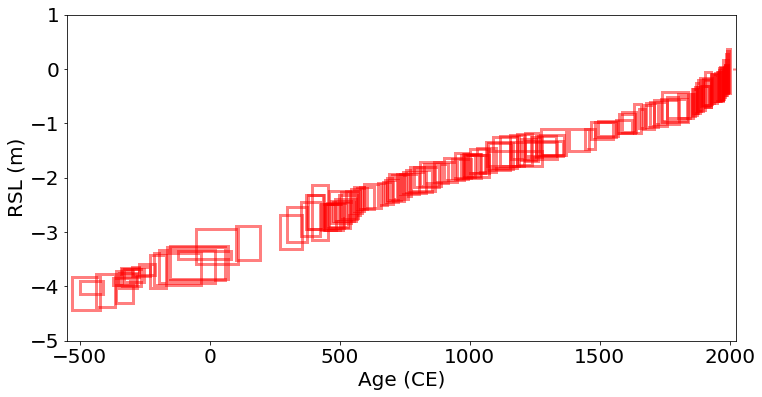

In [6]:
#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load_local_rsl_data('../../Data/NJ_CC.csv')

#visualize data
ax = PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

We can identify from the data that RSL change in New Jersey is non-linear with a potential abrupt RSL rise after 1900s. In this notebook, we will try to use the Gaussian Process Regression method in pyro to replicate the temporal trend of RSL change in [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130?casa_token=ehTQJ0z-n5UAAAAA:ZsNEE-ycwb8MiHR9pUTq2tjBoT-DjLeyPom7ANILl_euiU1xgyk093UZ7ZYwDc8MWrgMedgh8g#appsec2): 

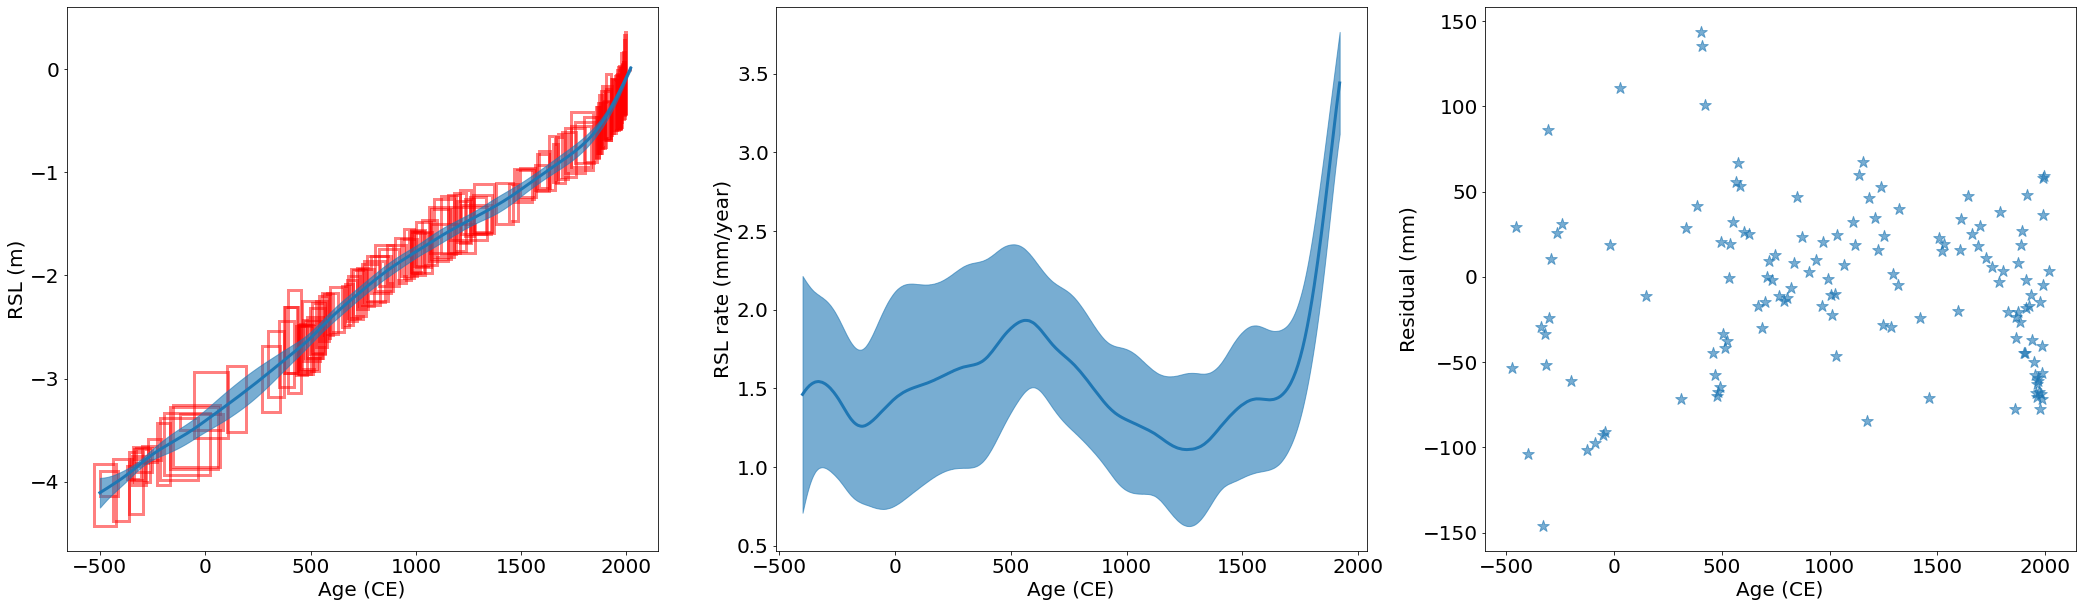

In [7]:
ashe_rsl_time = np.arange(-500,2025,5.)
ashe_mean_rsl = np.loadtxt('../../Data/ashe_mean.txt')/1000 #convert mm to m
cov_matrix = np.array(pd.read_csv('../../Data/ashe_cov.csv',header=None)) 
ashe_sd = np.sqrt(np.diag(cov_matrix))/1000
rsl_rate_time,ashe_rsl_rate,ashe_rsl_rate_sd = PSTHM.cal_rate_var(ashe_rsl_time,cov_matrix,ashe_mean_rsl)
ashe_rsl_rate_sd/=1000 #convert mm to m

#--------plotting---------
axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,ashe_rsl_time,ashe_mean_rsl,ashe_sd,
                          rsl_rate_time,ashe_rsl_rate,ashe_rsl_rate_sd)

### 1. Inferring sea-level change from data with no temporal uncertainty using one temporal scale GP kernel.

We will start with a easy case that we temporaly ignore the age uncertainty, hence we only consider vertical uncertainty from RSL reconstruction here. Additonally, we only use one kernel here, which is capable to capture sea-level process operating in one temporal scale. 

To start with, let's use a linear kernel, which is the same as doing Bayesian linear regression:
$$
k_{Linear}(t,t') = \sigma^2(\text{bias} + t \cdot t')
$$
where $\sigma$ and $bias$ are hyperparameters determines the rate and bias of this linear model. These hyperparamters can be optimized using either Emprical Bayes or Fully Bayesian analysis. $t$ and $t'$ denote each pair of input variables (i.e., age for RSL data), determining how far each pair of data apart in time. 

Empirical Bayes methods are procedures for statistical inference in which the prior probability distribution is estimated from the data. While Fully Bayesian analysis explicitly specifies prior distributions based on prior knowledge or beliefs. Both approaches utilize Bayesian inference, but their emphasis and application contexts differ. For a detailed example of difference between these two method for sea-level research, see [Piecuch et al., (2017)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC012506).

Here, we start with `Empirical Bayes Analysis`, where pyro adopts the [Stochastic Variational Inference (SVI)](https://pyro.ai/examples/svi_part_i.html) method. You can use GPRegreesion_V in PSTHM module to build a GP regression model with self-defined X (RSL age data), y (RSL data), y_sigma (RSL 1sigma vertical uncertainty) and kernel. You can see how can we generate a kernel below.


In [8]:
st = time.time() 

pyro.clear_param_store()

#generate a Linear kernel, note degree 1 polynomial kernel is a linear kernel 
Linear_kernel = gp.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(1.),variance=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, Linear_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,num_iteration=1000)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 7.036
Execution time: 2.736 s


For every excution, we print the prediction log likelihood and excution time, therefore you can get an idea of the goodness of fit and computational time for each method. We then plot the loss function (from SVI) and hyperparameters to check the convergence staus. After 1,000 iteration, we can see the loss function and hyperpameters are in stationary stage, which suggest we have a good estimate of hyperparameters now. Then, we can use the optimized hyperparameter to perform RSL prediction.

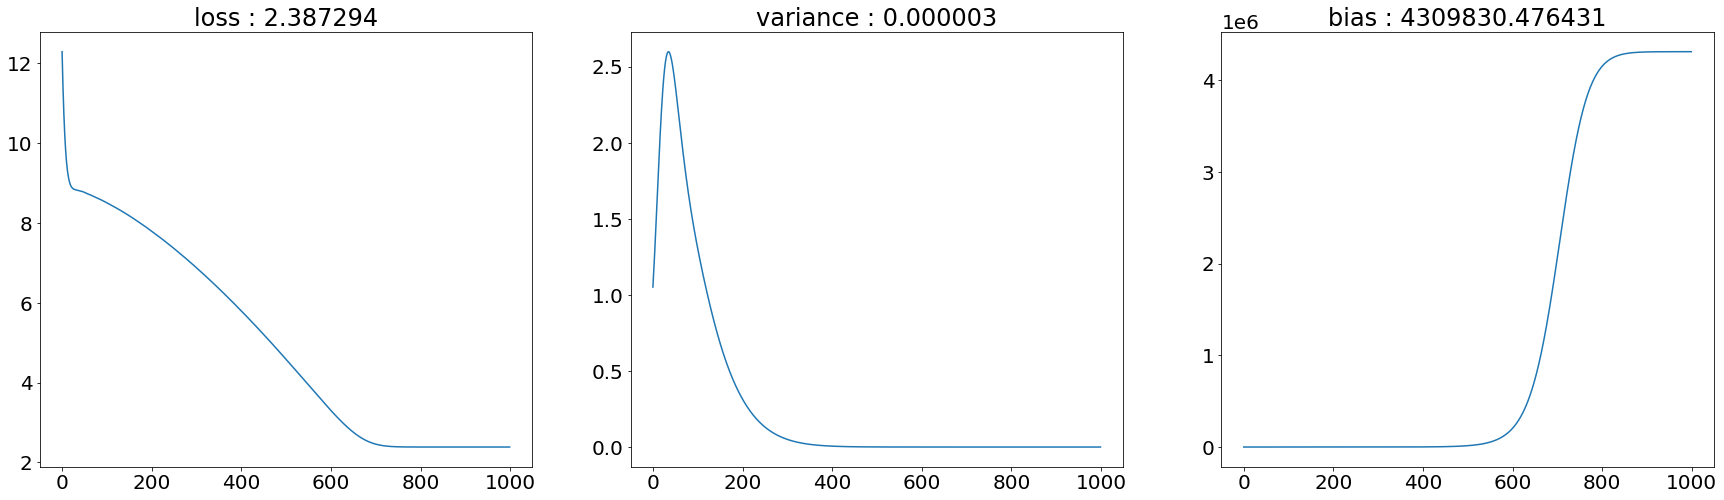

In [9]:
axes = PSTHM.plot_track_list(track_list)

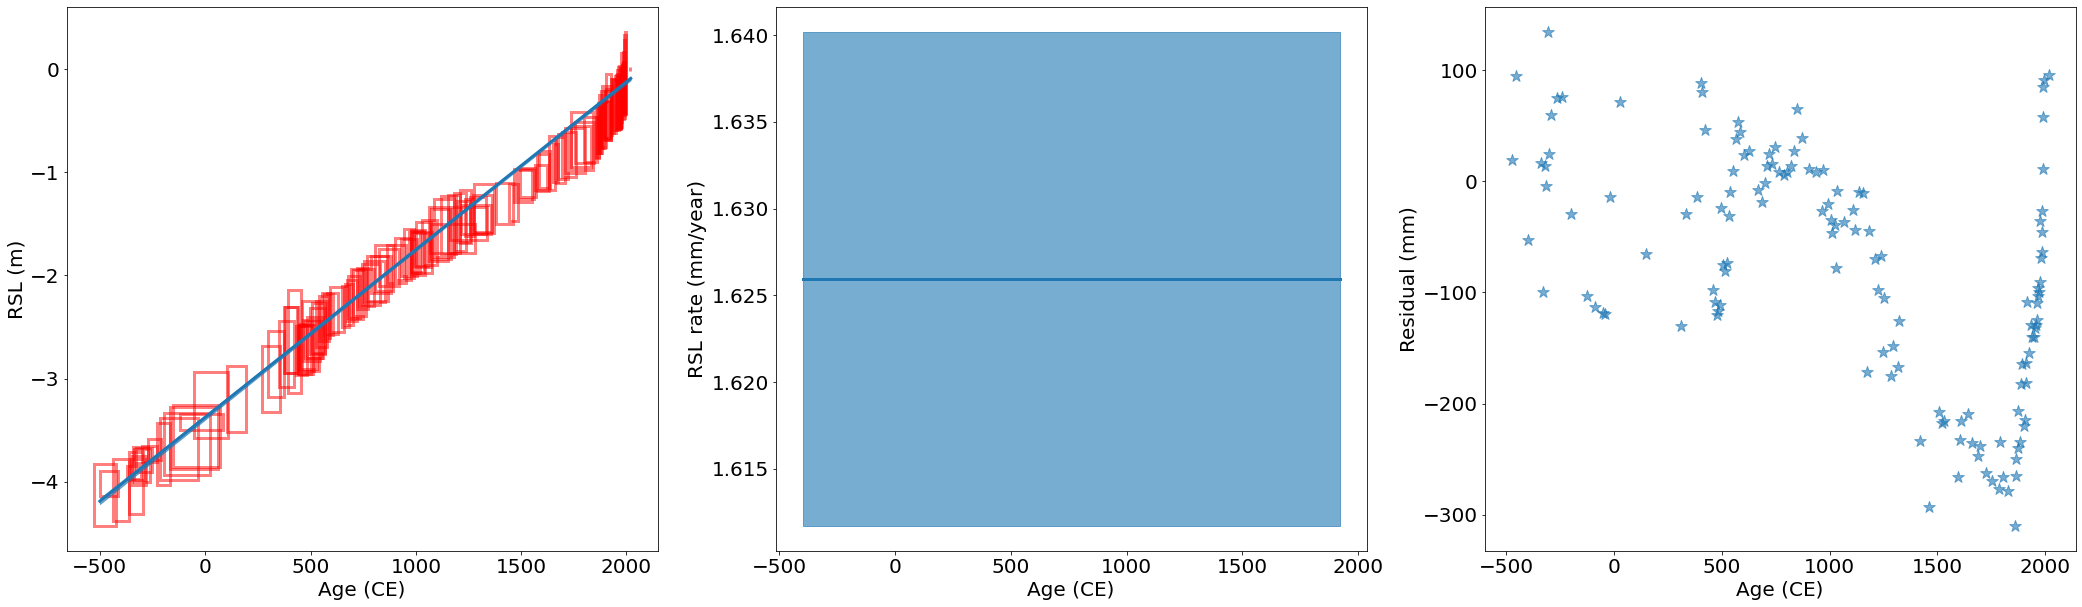

In [10]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.).double()
y_mean, y_var = gpr(x_test, full_cov=True,noiseless=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)


The linear kernel did a fairly good job on fitting the data, and it tells us sea-level rise rate in New Jersey from -500 CE to present is around 1.626 mm/yr, not bad! But if we look at the residual distribution, we can easily find some temporal structures, indicating this parametric linear model fails to capture some temporal variations of sea-level change process here. 

The good thing about GP is that it provides some unparametric kernels to determine RSL change processes without specifying a predetermined functional form, which is much flexible. To demostrate, we start with a squared exponential (i.e., [radial basis kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)), which is probably the most commonly-used kernel in GP:

$$
k_{RBF}(t,t') = \sigma^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$

where $\sigma$ is an amplitude hyperparameter and $l$ is a length scale hyperparameter. We will optimize these two RBF hyperparameters using Empirical Bayes and Fully Bayesian Analysis.   


In [11]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 163.452
Execution time: 2.854 s


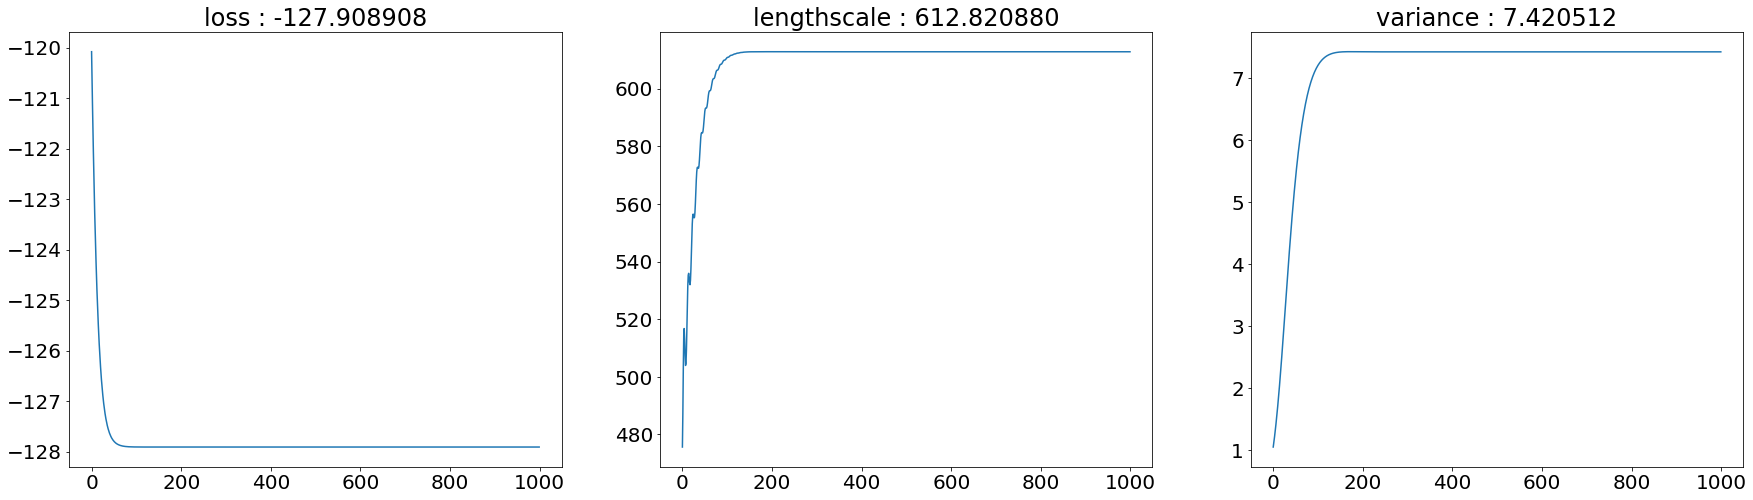

In [12]:
#Plot the optimization track 
axes = PSTHM.plot_track_list(track_list)

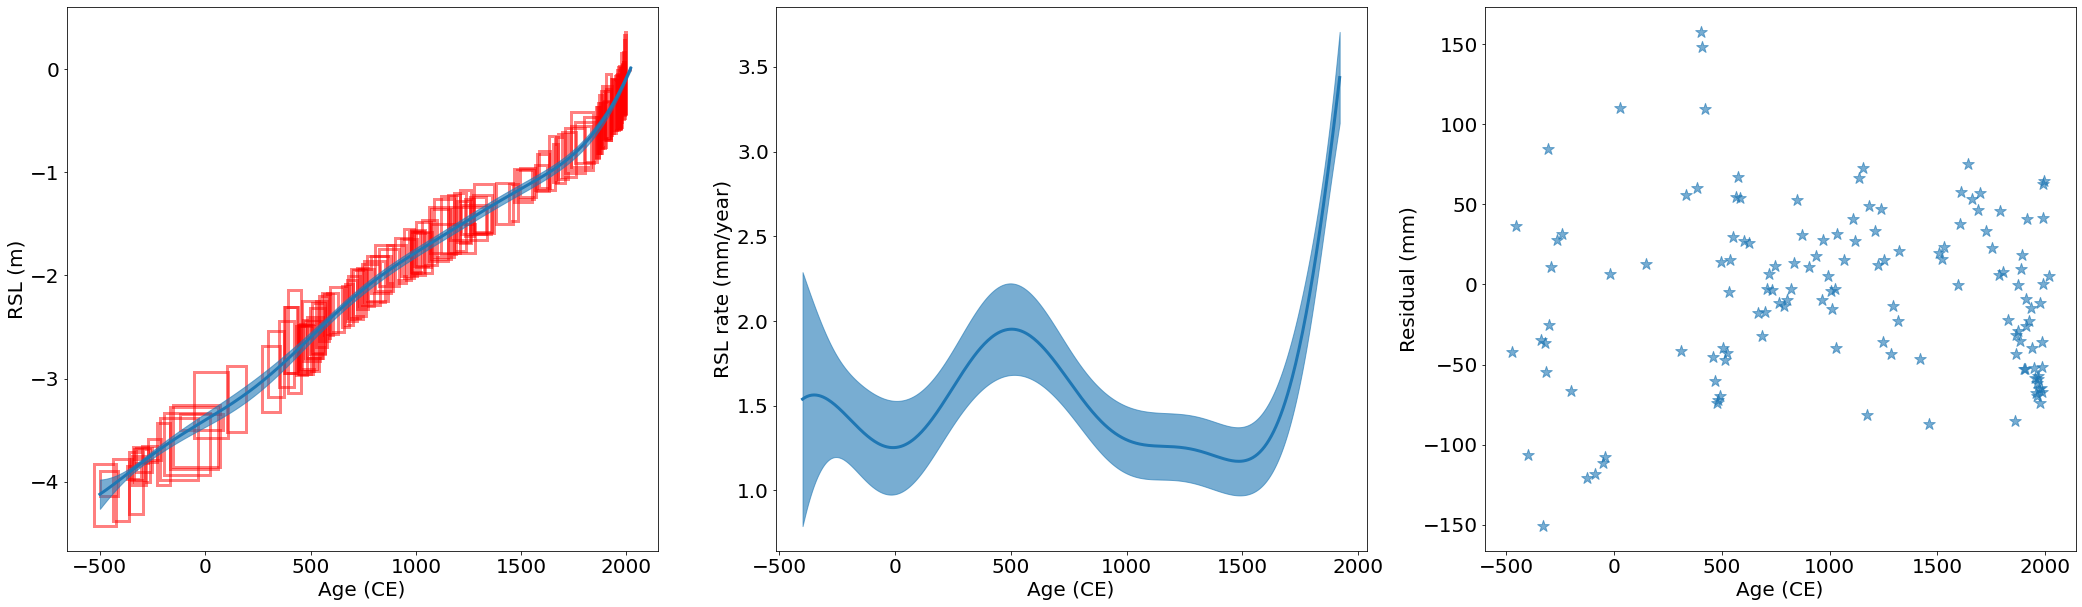

In [13]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.)
y_mean, y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)

Based on a RBF kernel, we can start to identify some temporal variation in sea-level change rate. We can easily find out that sea-level rise rate after 1500s started to rise substaintially, and after industrial revolution it increased to a 2000-year high level. Also, the residuals look much more stationary now, the larger residual at older age can be explained by larger sea-level reconstruction uncertainty back in time. 

Now let's try **Fully Bayesian Analysis** using [Markov Chain Monte Carlo (MCMC)](https://docs.pyro.ai/en/dev/mcmc.html) based algorithms. Specifically, we will use the No-U Turn Sampler ([NUTS](https://arxiv.org/abs/1111.4246)), which provides an efficient and automated way of running Hamiltonian Monte Carlo. For the Fully Bayesian Analysis, we need to define the prior distribution for each hyperparameters, the posterior distributions of hyperparameters represent a combined knowledge from our prior knowledge on a RSL process and observed RSL data. Here because we don't have too much prior knowledge, we use non-informative priors (i.e., uniform distribution over a large range).

Note, due to the fact tht we need MCMC based alrorithms to sample the posterior distribution of hyperparameters, Fully Bayesian Analysis tend to be much more computationally expensive compared to Empirical Bayes. Let's have a try:

In [10]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = gp.kernels.RBF(input_dim=1)
#set prior distributions for RBF hyperparameters
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-3), torch.tensor(1000.)))
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(3000.)))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#use NUTS mcmc to sample the posterior distribution of hyperparameters
#if this is too low, slightly decrease the target_accept_prob and restart again! 
# default target_accept_prob is 0.8 
mcmc = PSTHM.NUTS_mcmc(gpr,num_samples=4000,warmup_steps=200,print_stats=True)

#calulate log likelihood of the model prediction
#change kernel value to posterior mean 
RBF_kernel.variance = mcmc.get_samples()['kernel.variance'].mean()
RBF_kernel.variance = mcmc.get_samples()['kernel.lengthscale'].mean()
full_bayes_pred,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),full_bayes_pred.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


Sample: 100%|██████████| 4200/4200 [01:20, 52.06it/s, step size=2.97e-01, acc. prob=0.945]


-----kernel.lengthscale: 1328.18 +/ 517.69 (2sd)-----
Gelman-Rubin statistic for kernel.lengthscale: 1.00
Effective sample size for kernel.lengthscale: 1053.76
-----kernel.variance: 293.18 +/ 538.25 (2sd)-----
Gelman-Rubin statistic for kernel.variance: 1.00
Effective sample size for kernel.variance: 1011.71
Log Likelihood 153.182
Execution time: 80.848 s


After several minutes of computation, we now have the posterior distributions of two hyperparameters for the RBF kernel. It should be noted that, when working with any MCMC based approach, it is crucial to ensure that the Markov Chains have reached the stationary stage, indicating a good convergence stage and it can accurately represent the posterior distribution. One commonly used approach for assessing convergence is the Gelman-Rubin statistic. This statistical measure analyzes the differences between multiple Markov chains to evaluate convergence.

The Gelman-Rubin statistic assesses convergence by comparing the estimated between-chains and within-chain variances for each model parameter. Typically, a Gelman-Rubin statistic of less than 1.1 indicates good convergence, denoting that the Markov Chains have adequately explored the posterior distribution. We can see our Gelman-Rubin stats are both below 1.1 above, hence, the hyperparameters aboved should be converged, we can further confirm it by visulising the Markov Chain:

Text(0.5, 0, 'Samples')

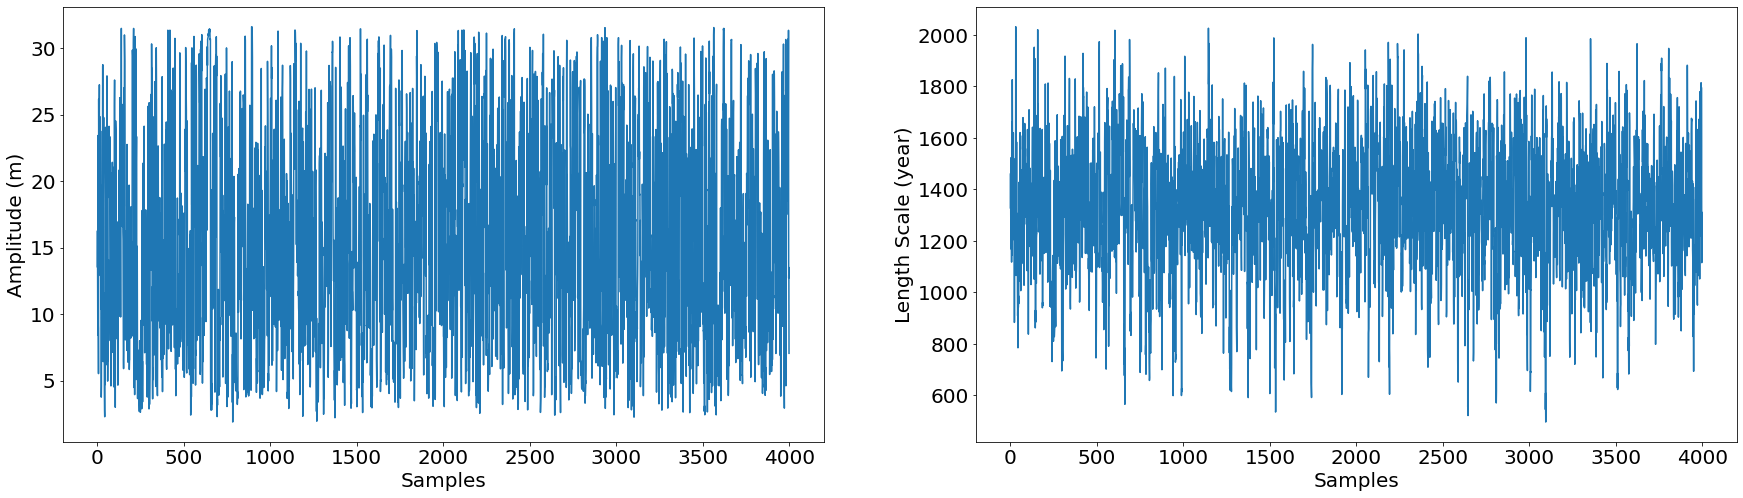

In [11]:
plt.figure(figsize=(30,8))
plt.subplot(121)
plt.plot(torch.arange(len(mcmc.get_samples()['kernel.variance'])),mcmc.get_samples()['kernel.variance']**0.5)
plt.ylabel('Amplitude (m)')
plt.xlabel('Samples')
plt.subplot(122)
plt.plot(torch.arange(len(mcmc.get_samples()['kernel.variance'])),mcmc.get_samples()['kernel.lengthscale'])
plt.ylabel('Length Scale (year)')
plt.xlabel('Samples')


Apart from convergence, we should further diagnose Markov Chain by checking the correlation between nearby Markov Chains. A good way for testing this is auto-correlation, which measures the degree of similarity between a time series and a lagged version of itself over successive time intervals. 


Auto-Correlation <0.05 from  7


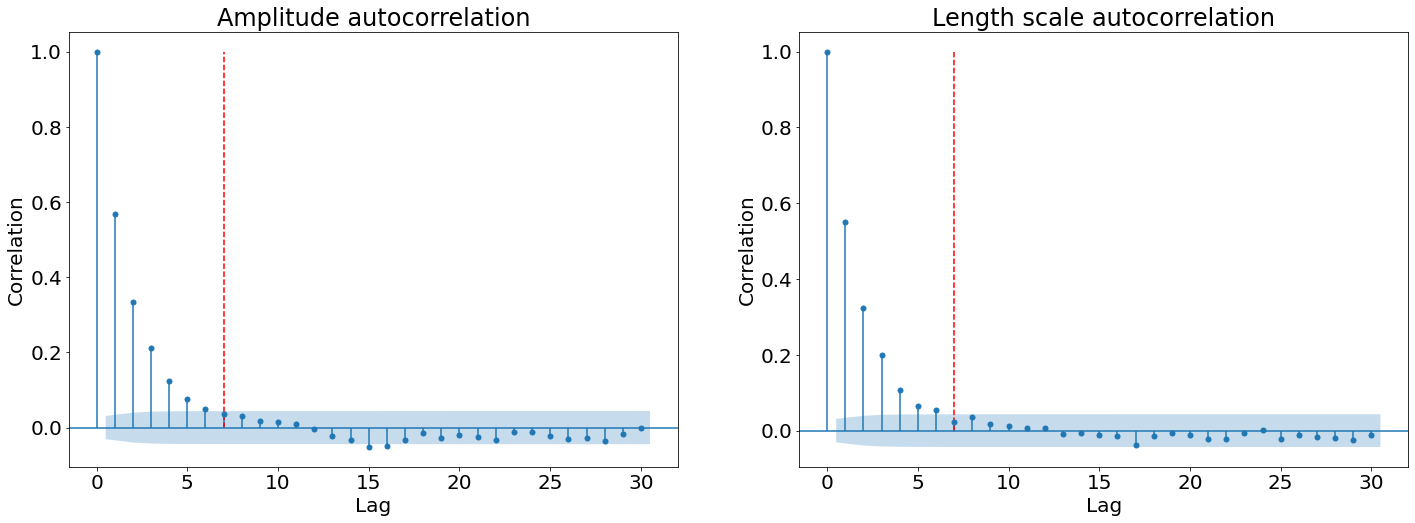

In [14]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm

#plot autocorrelation function
plt.figure(figsize=(24,8))
ax = plt.subplot(121)
variance_auto = sm.tsa.acf(mcmc.get_samples()['kernel.variance']**0.5)
ls_auto = sm.tsa.acf(mcmc.get_samples()['kernel.lengthscale'])
thin_index = np.argmax((np.abs(variance_auto)<0.05)&(np.abs(ls_auto)<0.05))

tsaplots.plot_acf(mcmc.get_samples()['kernel.variance']**0.5, lags=30,alpha=0.05,ax=ax,title='Amplitude autocorrelation')
ax.vlines(thin_index,0,1,color='r',linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlation')
ax2 = plt.subplot(122)
tsaplots.plot_acf(mcmc.get_samples()['kernel.lengthscale'], lags=30,ax=ax2,alpha=0.05,
                  title='Length scale autocorrelation');
ax2.vlines(thin_index,0,1,color='r',linestyle='--')

ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation')

print('Auto-Correlation <0.05 from ',thin_index)

Based on the auto-correlation resutls above, we can tell that the MCMC show sufficiently low correlation after several lags apart from each sample. Combinning this auto-correlation with the plots above demonstrate a good mixing result, (find details in section 6.7.1 [here](https://bookdown.org/marklhc/notes_bookdown/markov-chain-monte-carlo.html)). The reason why we worry about high-correlation between nearby sample is because it can significantly reduce the effective sample size of MCMC. For example, if a Markov Chain stuck in a place and cannot move out, the nearby samples should show a really high correlation and indicates the MCMC does not effectively sample the parameter space. 

Compared to traditional [metropolis-hastings MCMC](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), Hamiltonian Monte Carlo (HMC) based methods are much more efficient in getting samples with lower autocorrelations. This means that, the effective sample size for HMC is usually much higher than the metropolis-hastings MCMC when they have the same number of iterations. For example, with Gibbs sampling researchers usually need 50,000 or 100,000 iterations, whereas with STAN something around 1000-2000 would be enough for regression models. You might want to check [this animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana) of how these two types of MCMC work to sample a banana-shaped posterior distribution.

The results above show that the effective sample size for both hyperparameters are above 1000, so this MCMC is good to go. If not, you can go to the MCMC code and increase the sample size. Let's check the results! Now we can calculate the mean and covariance function based on posterior distributions. Becuase if we need to calculate covariance function for all MCMC samples, the calculation can be `pretty slow`. 

In this case, we can thin the MCMC by selecting every `n` th sample, you can choose `n` based on your computer capacity. The smaller `n` is, the slower the computation.

In [17]:
#predict the mean and variance of GP
x_test = torch.arange(-500,2025,5.) 

thin_index = 2 #if you want ot use full mcmc samples to calculate mean and variance, set thin_index = 1

full_bayes_mean,full_bayes_cov,full_bayes_sd,likelihood_list = PSTHM.mcmc_predict(gpr,mcmc,x_test,
                                                                                  thin_index=thin_index)

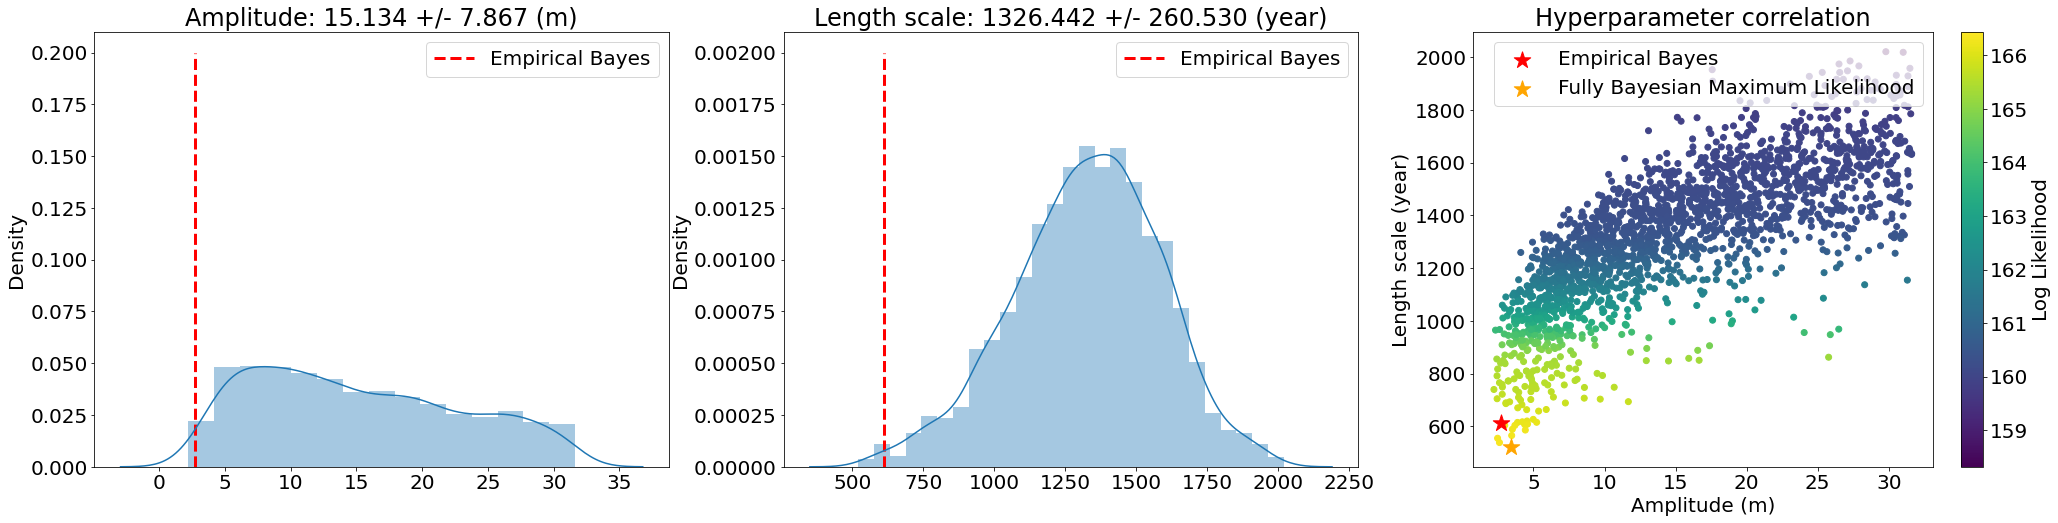

In [18]:
mcmc_variance = mcmc.get_samples()['kernel.variance'][::thin_index]
mcmc_lengthscale = mcmc.get_samples()['kernel.lengthscale'][::thin_index]

plt.figure(figsize=(35,8))
plt.subplot(131)
sns.distplot(mcmc_variance**0.5)
plt.vlines(track_list['variance'].iloc[-1]**0.5,0,0.20,color='r',linestyle='--',label='Empirical Bayes',linewidth=3)
plt.title('Amplitude: {:5.3f} +/- {:5.3f} (m)'.format(torch.mean(mcmc_variance**0.5),
                                            torch.std(mcmc_variance**0.5)))
plt.legend()
plt.subplot(132)
sns.distplot(mcmc_lengthscale)
plt.vlines(track_list['lengthscale'].iloc[-1],0,0.002,color='r',linestyle='--',label='Empirical Bayes',linewidth=3)
plt.title('Length scale: {:5.3f} +/- {:5.3f} (year)'.format(torch.mean(mcmc_lengthscale),
                                                           torch.std(mcmc_lengthscale)));
plt.legend()
plt.subplot(133)
fig =plt.scatter(mcmc_variance**0.5,mcmc_lengthscale,c=likelihood_list)
plt.scatter(track_list['variance'].iloc[-1]**0.5,track_list['lengthscale'].iloc[-1],color='r',marker='*',s=300,label='Empirical Bayes')
max_index = np.argmax(likelihood_list)
plt.scatter(mcmc_variance[max_index]**0.5,mcmc_lengthscale[max_index],color='orange',marker='*',s=300,label='Fully Bayesian Maximum Likelihood')

cbar = plt.colorbar(fig)
cbar.set_label('Log Likelihood')
plt.xlabel('Amplitude (m)')
plt.ylabel('Length scale (year)')
plt.title('Hyperparameter correlation')
plt.legend(loc=1);


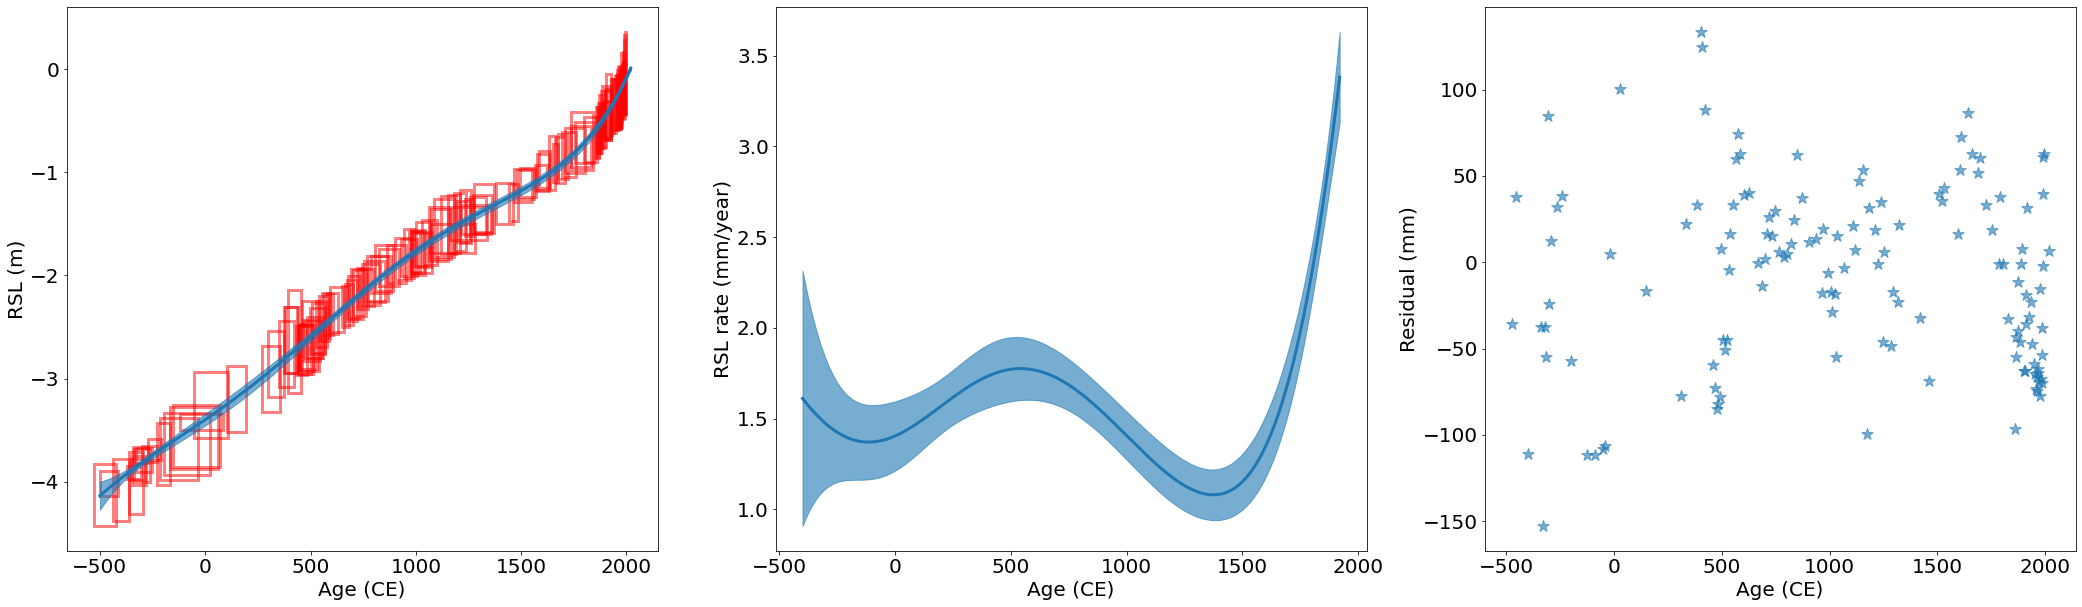

In [20]:
full_bayes_x_test = torch.arange(-500,2025,5.)

full_bayes_rsl_time,full_bayes_rate,full_bayes_rate_sd = PSTHM.cal_rate_var(full_bayes_x_test.detach().numpy(),full_bayes_cov,full_bayes_mean)

axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,full_bayes_x_test,full_bayes_mean,full_bayes_sd,
                          full_bayes_rsl_time,full_bayes_rate,full_bayes_rate_sd)

#### Compare Empirical Bayes with Fully Bayesian anslysis

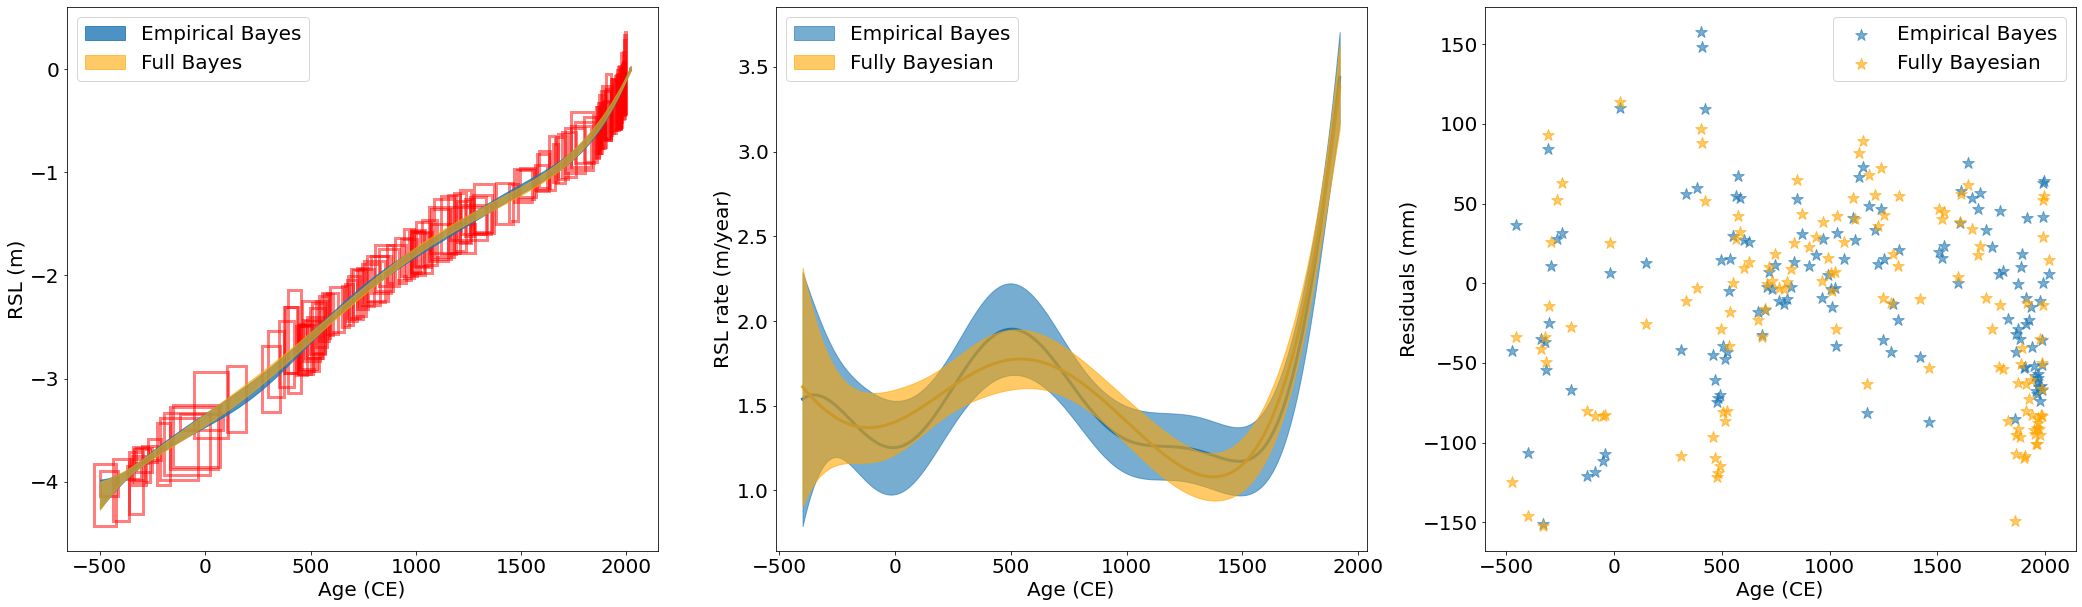

In [21]:
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (y_mean - 2.0 * sd).detach().numpy(),
            (y_mean + 2.0 * sd).detach().numpy(),
            color="C0",
            alpha=0.8,zorder=10,label='Empirical Bayes')
ax.fill_between(
            full_bayes_x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (full_bayes_mean - 2.0 * full_bayes_sd),
            (full_bayes_mean + 2.0 * full_bayes_sd),
            color="orange",
            alpha=0.6,zorder=10,label='Full Bayes')
ax.legend()


ax = plt.subplot(132)
plt.plot(rsl_time,rsl_rate*1000,linewidth=3,color='C0')

ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (rsl_rate - 2.0 * rsl_rate_sd)*1000,
            (rsl_rate + 2.0 * rsl_rate_sd)*1000,
            color="C0",
            alpha=0.6,zorder=10,label='Empirical Bayes')

plt.plot(full_bayes_rsl_time,full_bayes_rate*1000,linewidth=3,color='orange')

ax.fill_between(
            full_bayes_rsl_time,  # plot the two-sigma uncertainty about the mean
            (full_bayes_rate - 2.0 * full_bayes_rate_sd)*1000,
            (full_bayes_rate + 2.0 * full_bayes_rate_sd)*1000,
            color="orange",
            alpha=0.6,zorder=10,label='Fully Bayesian')
plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (m/year)')
ax.legend(loc=2)



ax = plt.subplot(133)
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',alpha=0.6,label='Empirical Bayes')

plt.scatter(X,(y-full_bayes_pred.detach().numpy())*1000,s=150,marker='*',alpha=0.6,label='Fully Bayesian',color='orange')
plt.legend()
plt.ylabel('Residuals (mm)')
plt.xlabel('Age (CE)');

For a single RBF kernel, the Empirical Bayes and Fully Bayesian Analysis seem to show slightly different results. Although you might find the posterior distributions of variance and length scale parameters for Fully Bayesian Analysis covers a much wide range, but due to the trade-off between variance and length scale parameters (you can easily find a postive correlation between two hyperparameters in the correlation plot above), the resulting predictions are similar. It should be noticed that the prior distributions have hugh impact on the resulting posterior distribution, so make sure you have enough information about the process before putting any informative priors. 

### Alternative kernel function

You might be able to identify that RSL change quite smoothly in the plots above. This is because the nature of RBF kernel, which is infinitely differentiable, indicating it assumes RSL change very smoothly without abrupt change. However, this is usually not the case for sea level as it might change abruptly due to climate change. 

To represent on this knowledge, we can use althernative kernel options that are more flexible. An good example is 3/2 Matérn kernel:

$$
k_{M3}(t, t') = \sigma^2\left(1 + \sqrt{3} \times \frac{|t-t'|}{l}\right)
        \exp\left(-\sqrt{3} \times \frac{|t-t'|}{l}\right)
$$

similar to RBF kernel above, $\sigma$ is an amplitude hyperparameter and $l$ is a length scale hyperparameter. Becuase 3/2 Matérn kernel is only once differentiable, it allows sea-level to change more abruptly. 

In [22]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern32 kernel 
Matern32_kernel = gp.kernels.Matern32(input_dim=1,variance=torch.tensor(10.),lengthscale=torch.tensor(10000.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.GPRegression_V(X, y, Matern32_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 165.505
Execution time: 2.984 s


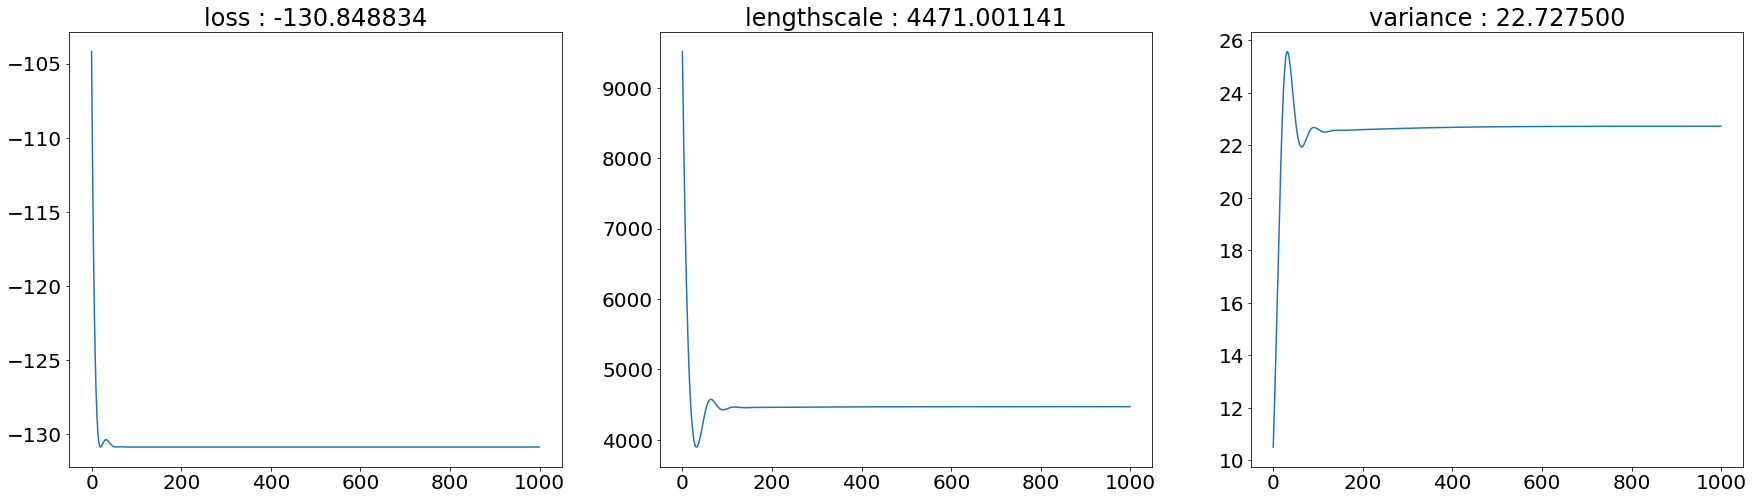

In [23]:
axes = PSTHM.plot_track_list(track_list)

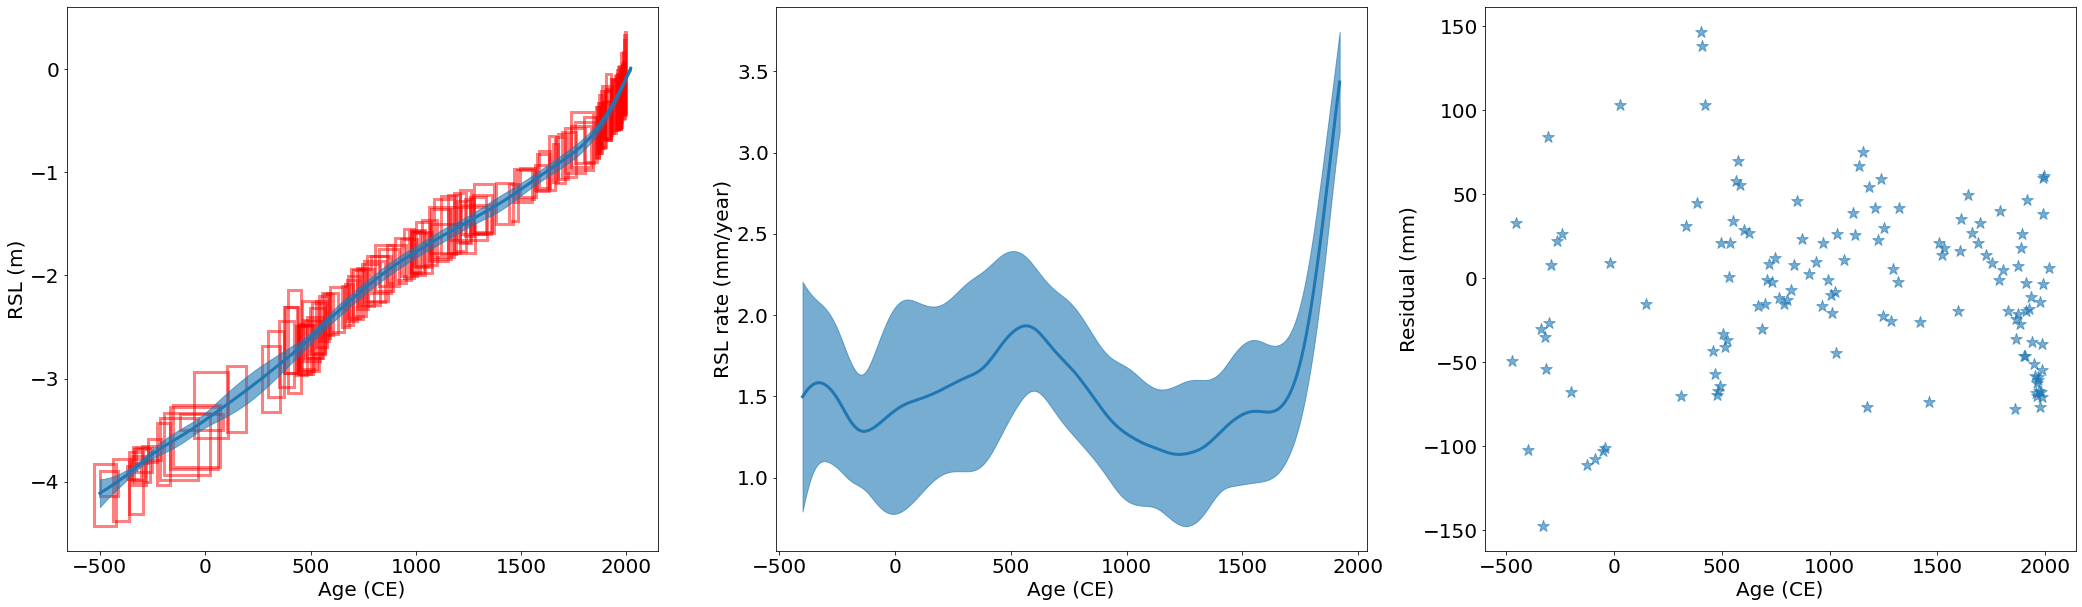

In [24]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
Matern32_y_mean, Matern32_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
Matern32_sd = torch.diag(Matern32_y_var).sqrt()  # standard deviation at each input point x
rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),Matern32_y_var.detach().numpy(),Matern32_y_mean.detach().numpy())

axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,x_test,Matern32_y_mean,Matern32_sd,
                          rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd)

Again, because the 3/2 Matérn kernel is only once differentiable, it is able to capture more short wavelength information and shows higher log likelihood compared with RBF kernel, not bad! 

### 2. Inferring sea-level change from data with no temporal uncertainty using multiple temporal scale GP kernels. 

Although the predictions by a single 3/2 Matérn kernel looks better then the RBF kernel, it can still be improved by incorporating multiple kernels. For example, [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130?casa_token=ehTQJ0z-n5UAAAAA:ZsNEE-ycwb8MiHR9pUTq2tjBoT-DjLeyPom7ANILl_euiU1xgyk093UZ7ZYwDc8MWrgMedgh8g) use a 3/2 Matérn kernel with large variance and length scale hyperparameters to represent global sea-level change trend along with a 3/2 Matérn kernel with medium variance and length scale to indicate regional sea-level variance. Additionally, they also include a white-noise kernel to reflect local RSL signal/noise:
$$
k_{Whitenoise}(t,t') = \sigma^2 \delta(t,t')
$$
where $\delta$ is a Dirac delta function and $\sigma$ is an amplitude hyperparameter.

This can be done in pyro by setting the prior distribution for different hyperparameters for different kernels. Let's try this!


In [25]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate kernels 
Matern32_kernel = gp.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = gp.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))

Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(combined_kernel, Whitenoise_kernel)

gpr = PSTHM.GPRegression_V(X, y, combined_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/1000 [00:00<?, ?it/s]

Likelihood 164.700
Execution time: 5.236 s


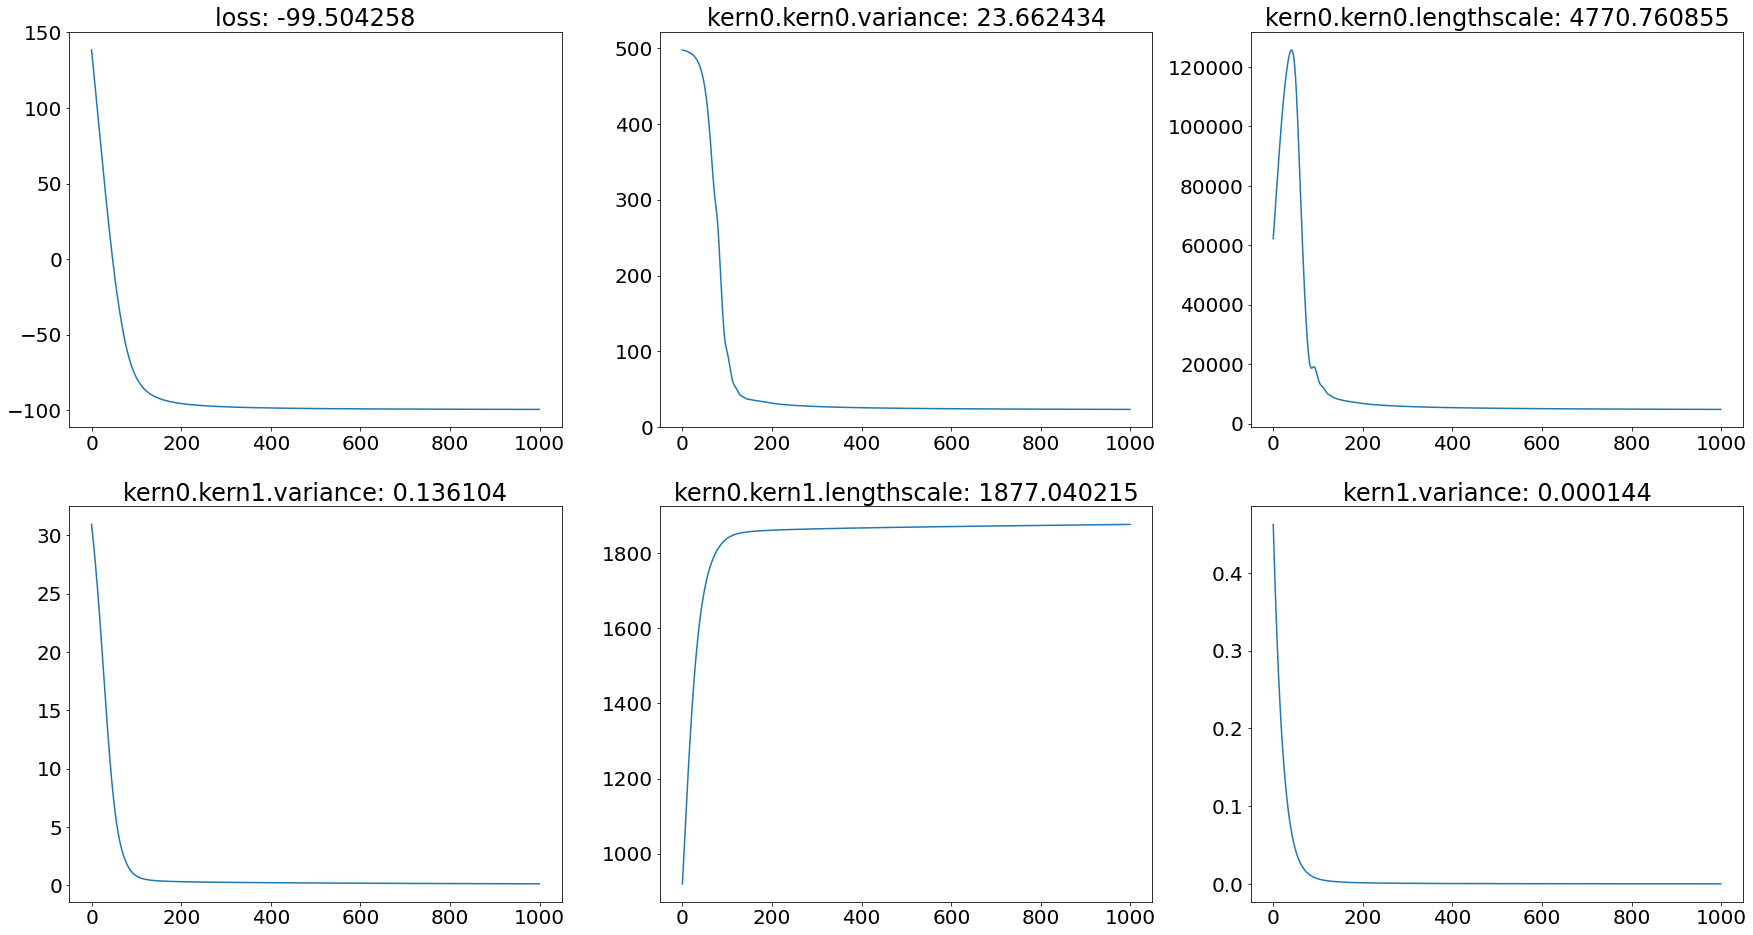

In [26]:
axes = PSTHM.plot_track_list(track_list)

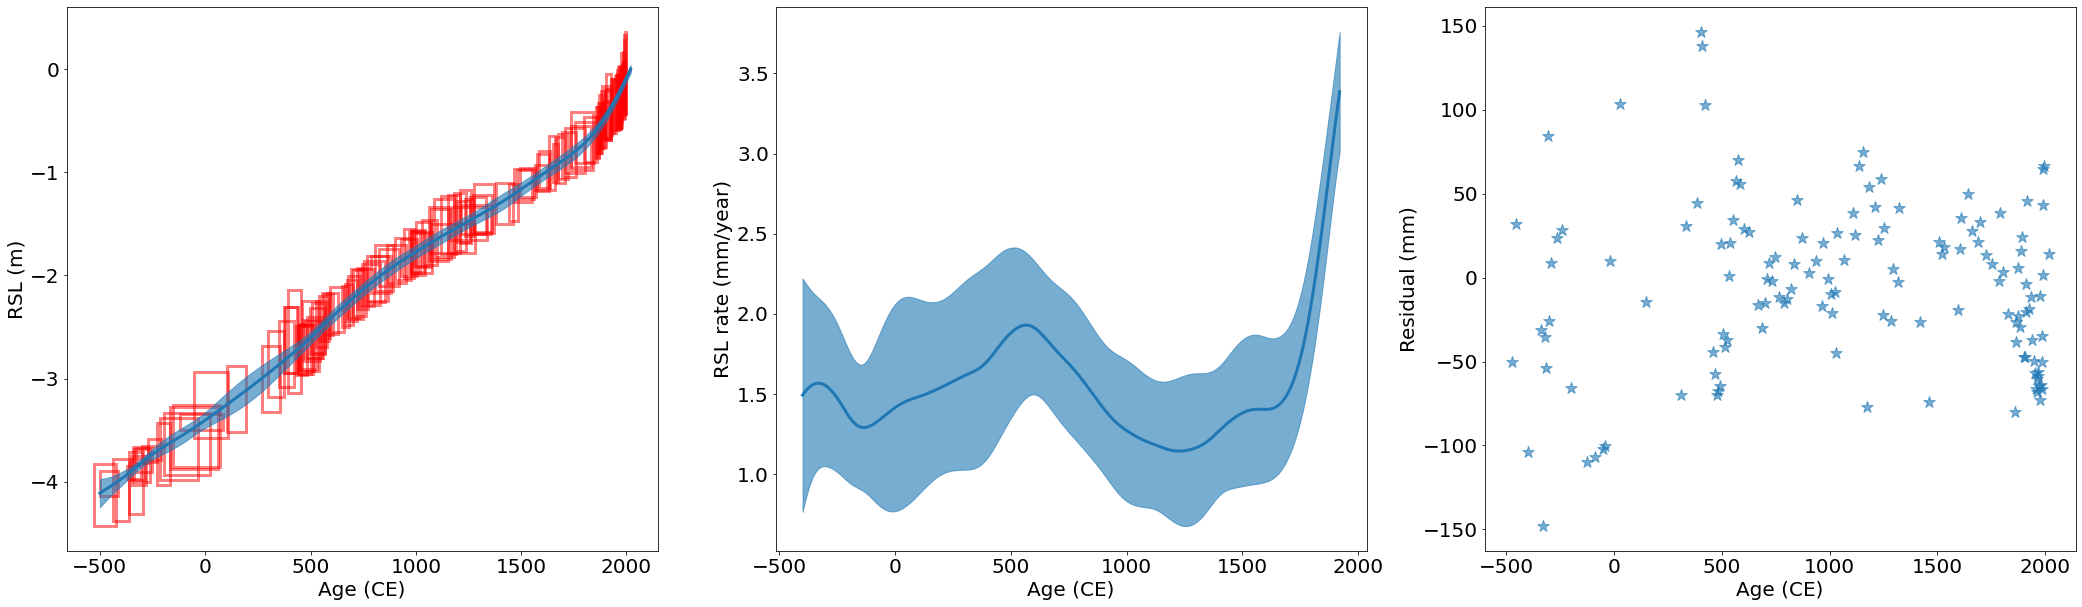

In [27]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)

### 3. Inferring sea-level change from data with data-point-independent temporal uncertainty using multiple temporal scale GP kernels.

Ok, one thing we keep ignoring is the temporal uncertainty. One easy way to incorporate temporal uncertainty in GP regression is noisy-input GP, introduced by [McHutchon and Rasmussen (2011)](https://proceedings.neurips.cc/paper_files/paper/2011/file/a8e864d04c95572d1aece099af852d0a-Paper.pdf), where temporal uncertainty can be translated into equivalent RSL uncertainty based on squared gradient of the GP posterior mean. The code below is the same as the code above, the only difference is we furhter considering the temporal uncertainty for each RSL data based on RSL gradient calculated above.

In [28]:

from tqdm.notebook import tqdm
# calculate computational time
st = time.time() 

pyro.clear_param_store()


#generate kernels
Matern32_kernel = gp.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = gp.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))


Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(combined_kernel, Whitenoise_kernel)

gpr = PSTHM.GPRegression_V(X, y, combined_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization for noisy-input GP, we need to provide x_sigma here
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/1000 [00:00<?, ?it/s]

Likelihood 164.418
Execution time: 5.241 s


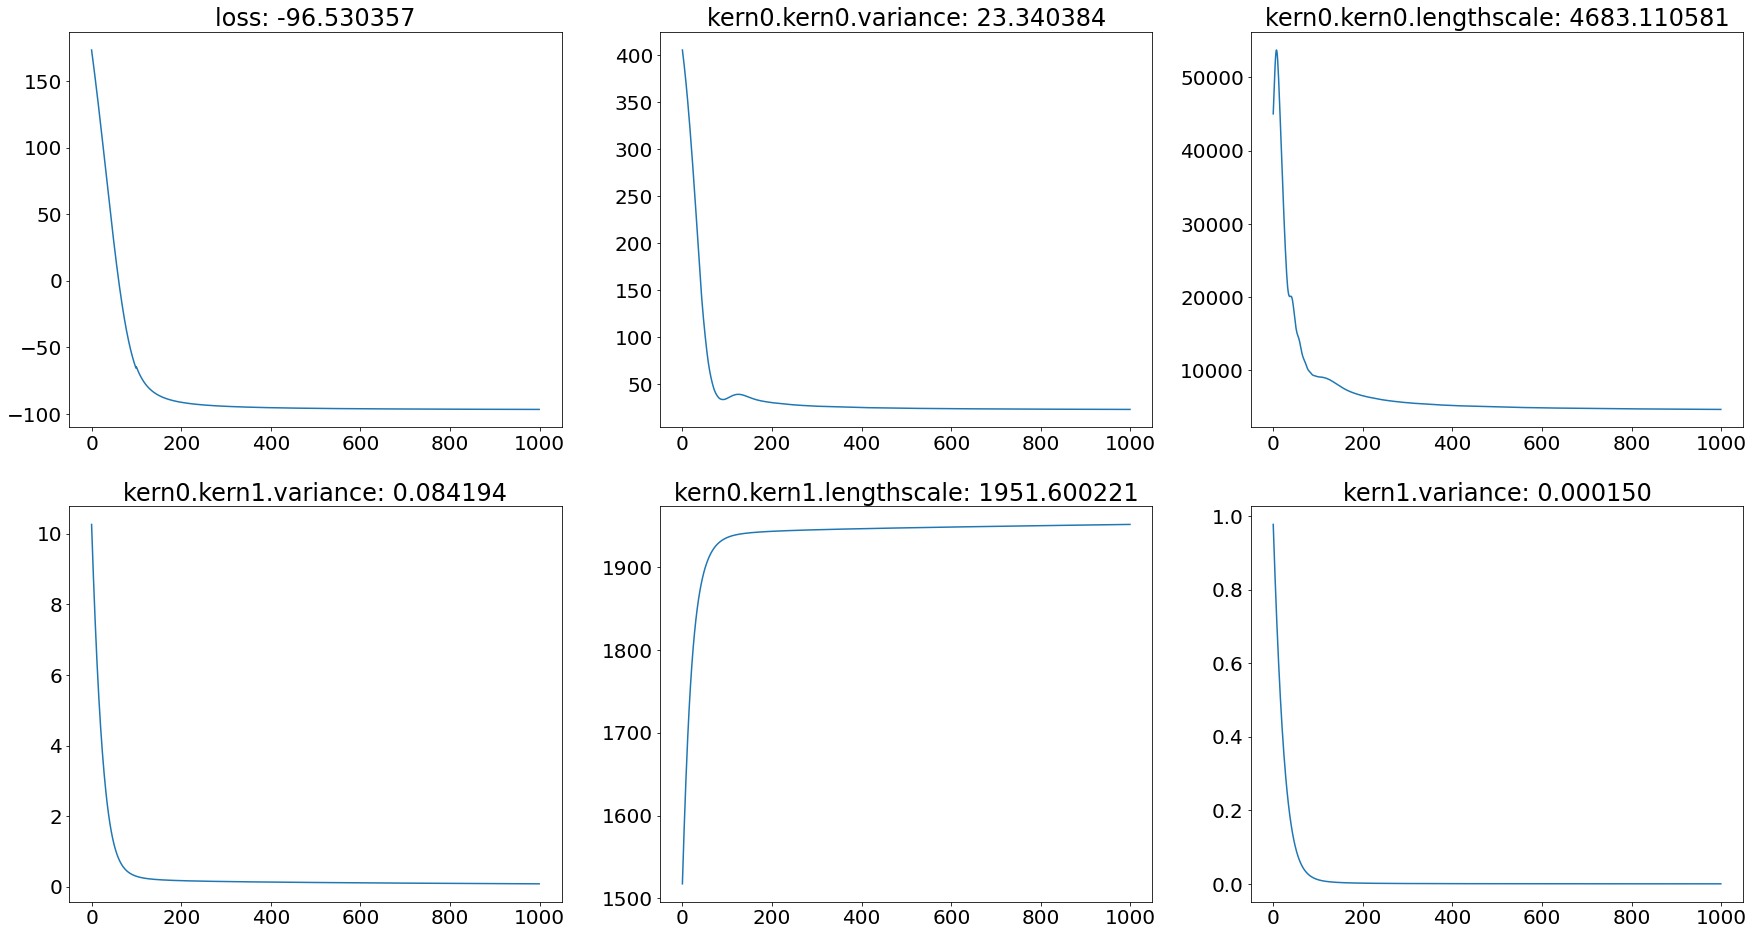

In [29]:
axes = PSTHM.plot_track_list(track_list)

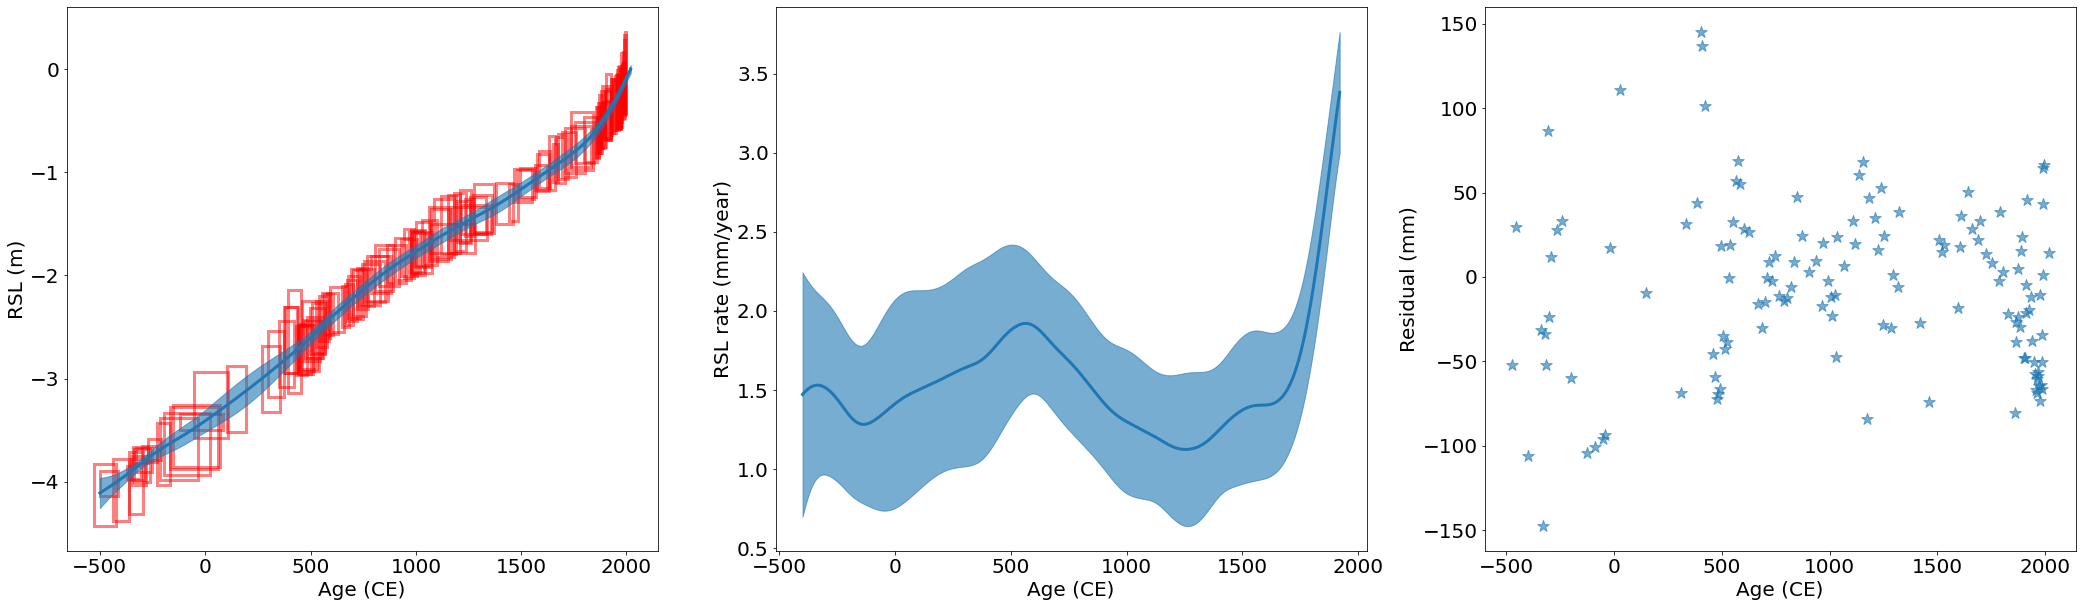

In [30]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plot_tem_regreesion(X,y,x_sigma,y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)


You might find considering temporal uncertainty producing minor impact on the final prediction here, but it turns out that sometimes temporal uncertainty will have a huge impact on the prediction uncertainty. You can find more details in another tutorial notebook named `PaleoSTeHM_EIV_NI`.

### Comparison

So let's now compare our modelling results with published results by Ashe et al., 2019.

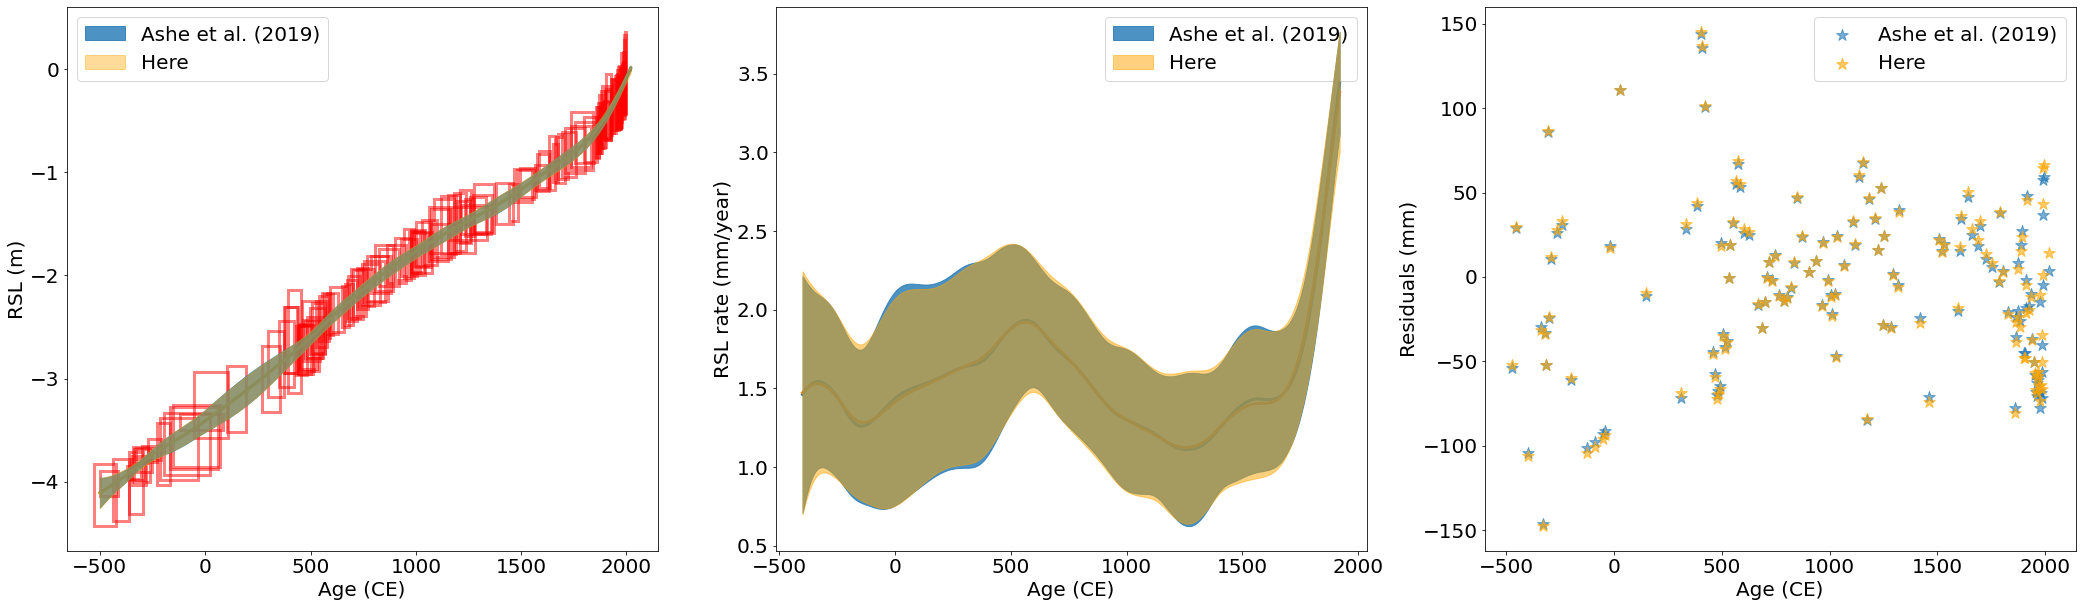

In [31]:
#-----plotting---------
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
PSTHM.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)

plt.plot(ashe_rsl_time,ashe_mean_rsl,linewidth=3)
plt.plot(x_test.detach().numpy(),c_kernel_y_mean.detach().numpy(),linewidth=3,color='orange',alpha=0.8)

plt.fill_between(
            ashe_rsl_time,  # plot the two-sigma uncertainty about the mean
            (ashe_mean_rsl - 2.0 * ashe_sd),
            (ashe_mean_rsl + 2.0 * ashe_sd),
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al. (2019)')
ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="orange",
            alpha=0.4,zorder=10,label='Here')
plt.legend()
ax = plt.subplot(132)
ax.plot(rsl_rate_time,ashe_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_rate_time,  # plot the two-sigma uncertainty about the mean
            (ashe_rsl_rate - 2.0 * ashe_rsl_rate_sd)*1000,
            (ashe_rsl_rate + 2.0 * ashe_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al. (2019)')

plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="orange",
            alpha=0.5,zorder=10,label='Here')

plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')
plt.legend()

ax = plt.subplot(133)
f_ashe = interpolate.interp1d(ashe_rsl_time,ashe_mean_rsl)
plt.scatter(X,(y-f_ashe(X))*1000,s=150,marker='*',color='C0',alpha=0.6,label='Ashe et al. (2019)')
plt.scatter(X,(y-pred_y.detach().numpy())*1000,s=150,marker='*',color='orange',alpha=0.6,label='Here')
plt.xlabel('Age (CE)')
plt.ylabel('Residuals (mm)')
plt.legend();

The resulting inference are pretty much the same! So now you know how to do empirical temporal Gaussian process (ET-GP in [Ashe et al., (2019)](https://www.sciencedirect.com/science/article/pii/S0277379118302130?casa_token=lkL4EQzNcYUAAAAA:PJwiPDwNVwAViJLzpkDEnATGd5B8nKAIi5mN-ls9ITH-EltM7n0XqY5xWIL29IwFA-NyGPPECw#fig3)). We let's wrap it up for a new RSL site in Northern North Carolina by [Kemp et al., 2011](https://www.pnas.org/doi/abs/10.1073/pnas.1015619108)!

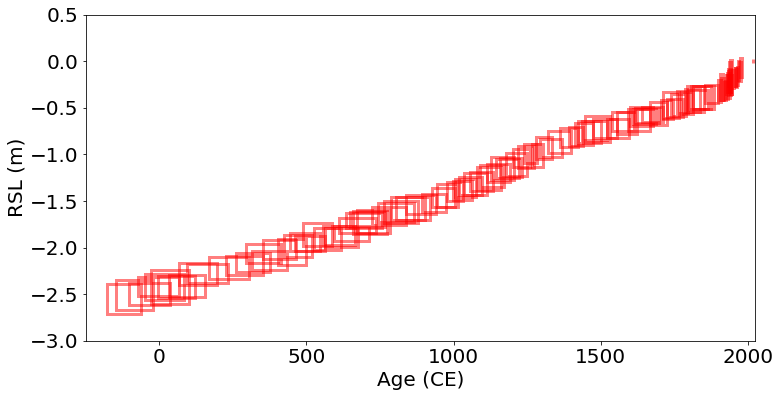

In [32]:
#load data 
NNC_X,NNC_y,NNC_y_sigma,NNC_x_sigma,NNC_lon,NNC_lat = PSTHM.load_local_rsl_data('../Data/NNC_CC.csv')

#visualize data
ax = PSTHM.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2)
ax.set_xlim(-250,2025)
ax.set_ylim(-3,0.5)
plt.show();

In [33]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate kernels 
Matern32_kernel = gp.kernels.Matern32(
    input_dim=1,variance=torch.tensor(60**2),lengthscale=torch.tensor(12000))
Matern32_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
Matern32_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(2000.), torch.tensor(200000.)))

Matern32_kernel2 = gp.kernels.Matern32(
    input_dim=1)
Matern32_kernel2.set_prior("variance", dist.Uniform(torch.tensor(0.01), torch.tensor(40.)))
Matern32_kernel2.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(2000.)))

Whitenoise_kernel = gp.kernels.WhiteNoise(
    input_dim=1, variance=torch.tensor(1))
Whitenoise_kernel.set_prior('variance', dist.Uniform(torch.tensor(1e-3**2), torch.tensor(2**2)))

combined_kernel = gp.kernels.Sum(Matern32_kernel, Matern32_kernel2)
combined_kernel = gp.kernels.Sum(combined_kernel, Whitenoise_kernel)

gpr = PSTHM.GPRegression_V(NNC_X, NNC_y, combined_kernel,noise=torch.tensor(NNC_y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,NNC_x_sigma,num_iteration=1500,update_fre=200)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(NNC_X.double(), full_cov=True)

fit_likelihood = PSTHM.cal_likelihood(NNC_y.detach().numpy(),NNC_y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

  0%|          | 0/1500 [00:00<?, ?it/s]

Likelihood 208.487
Execution time: 7.264 s


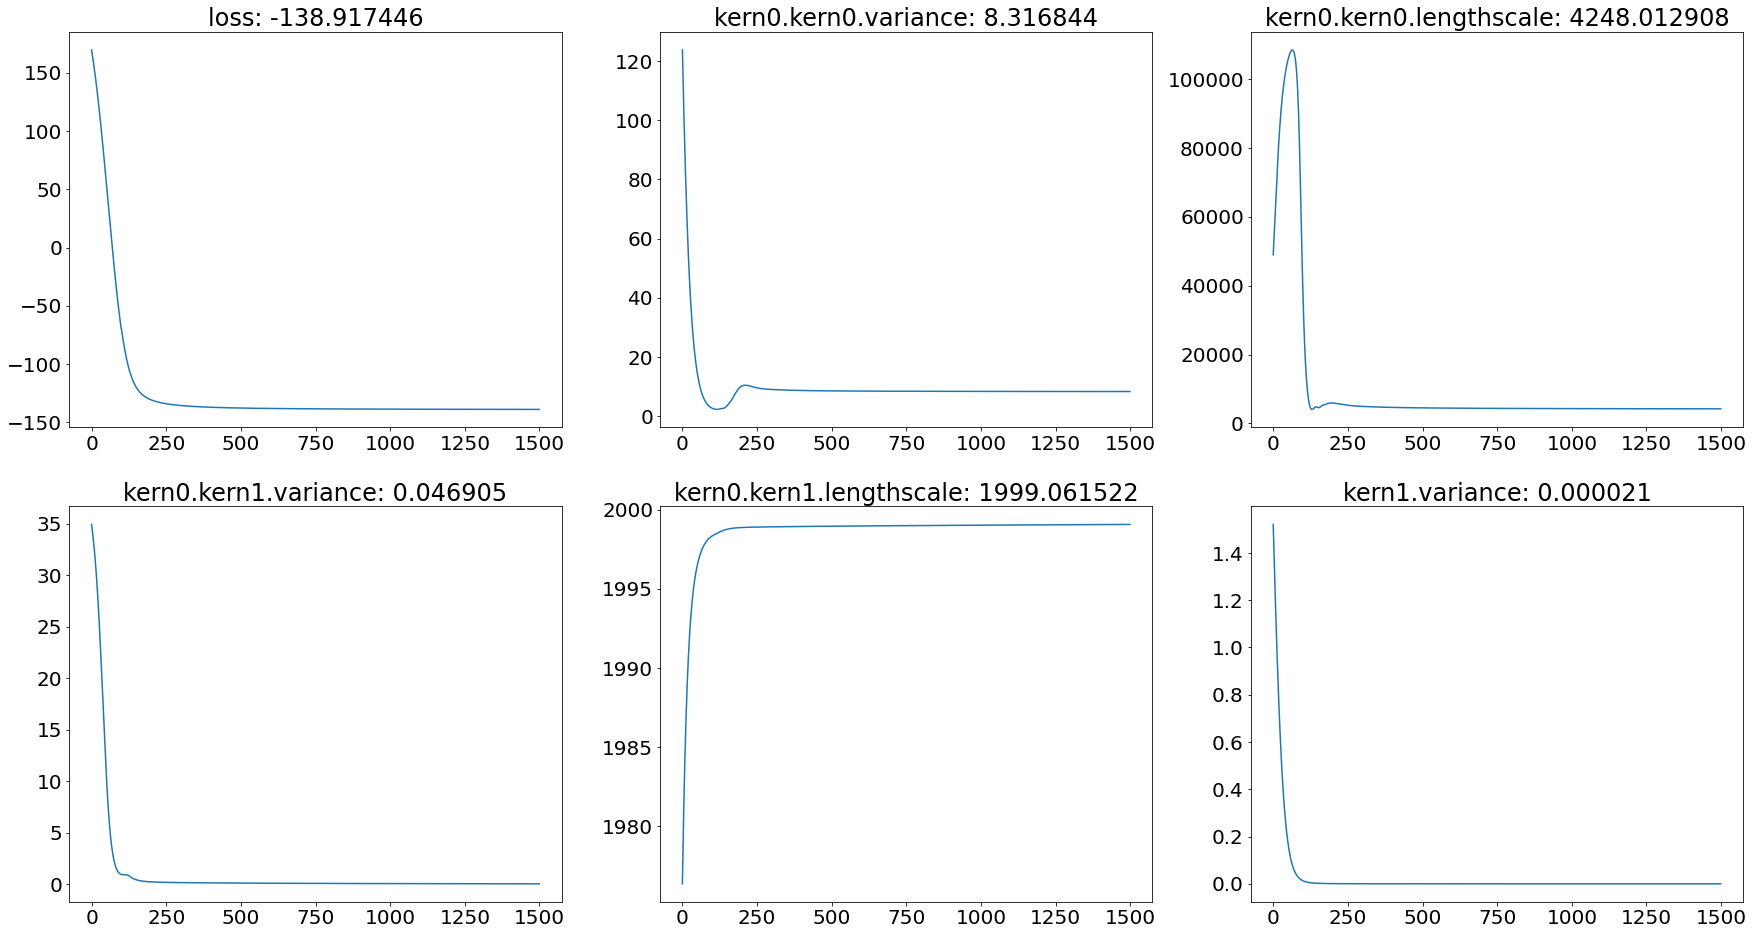

In [34]:
axes = PSTHM.plot_track_list(track_list)

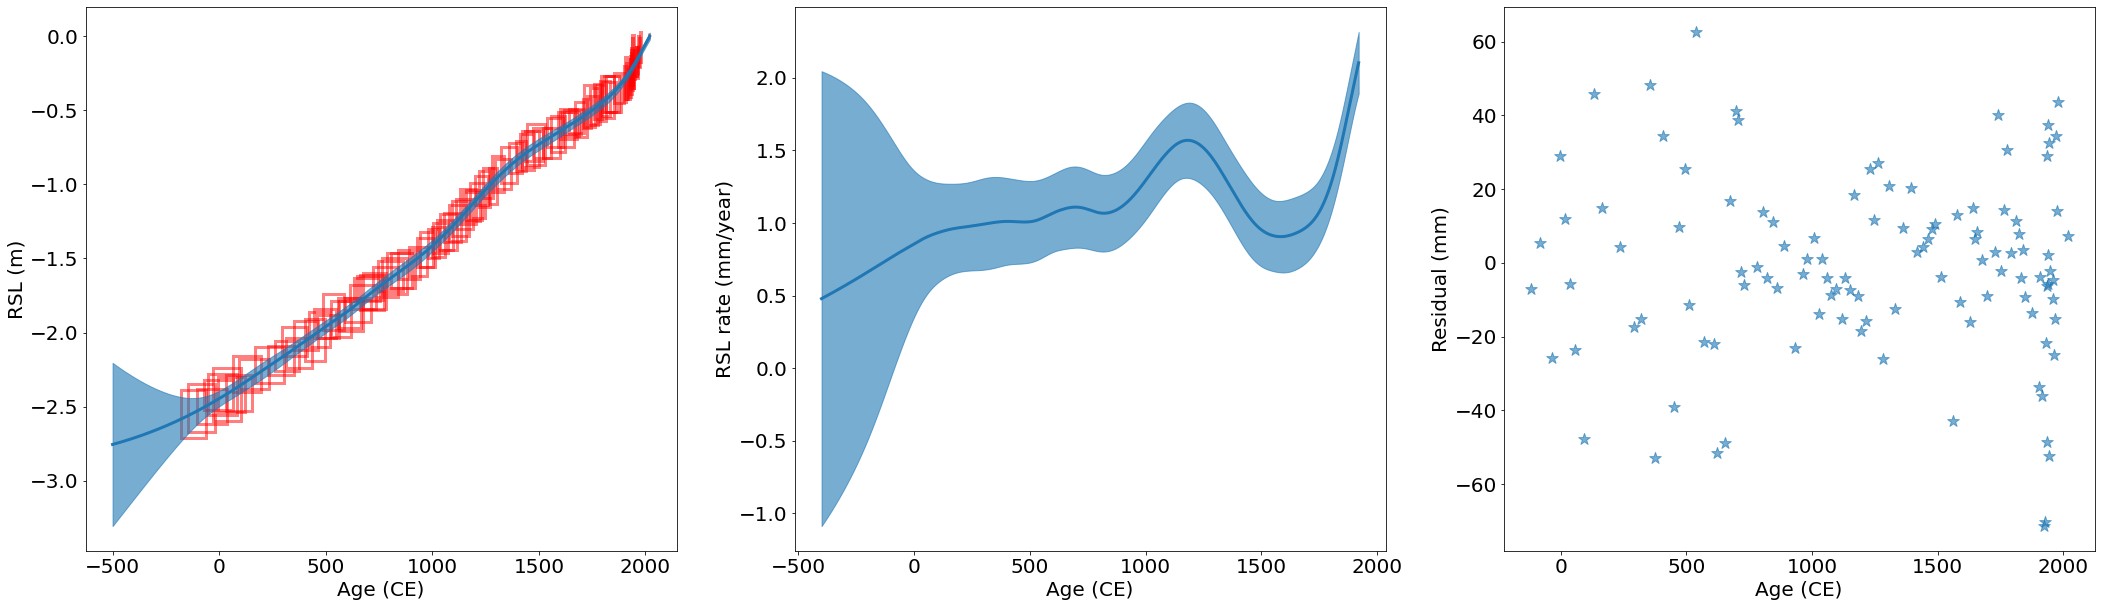

In [35]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True,noiseless=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plot_tem_regreesion(NNC_X,NNC_y,NNC_x_sigma,NNC_y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)

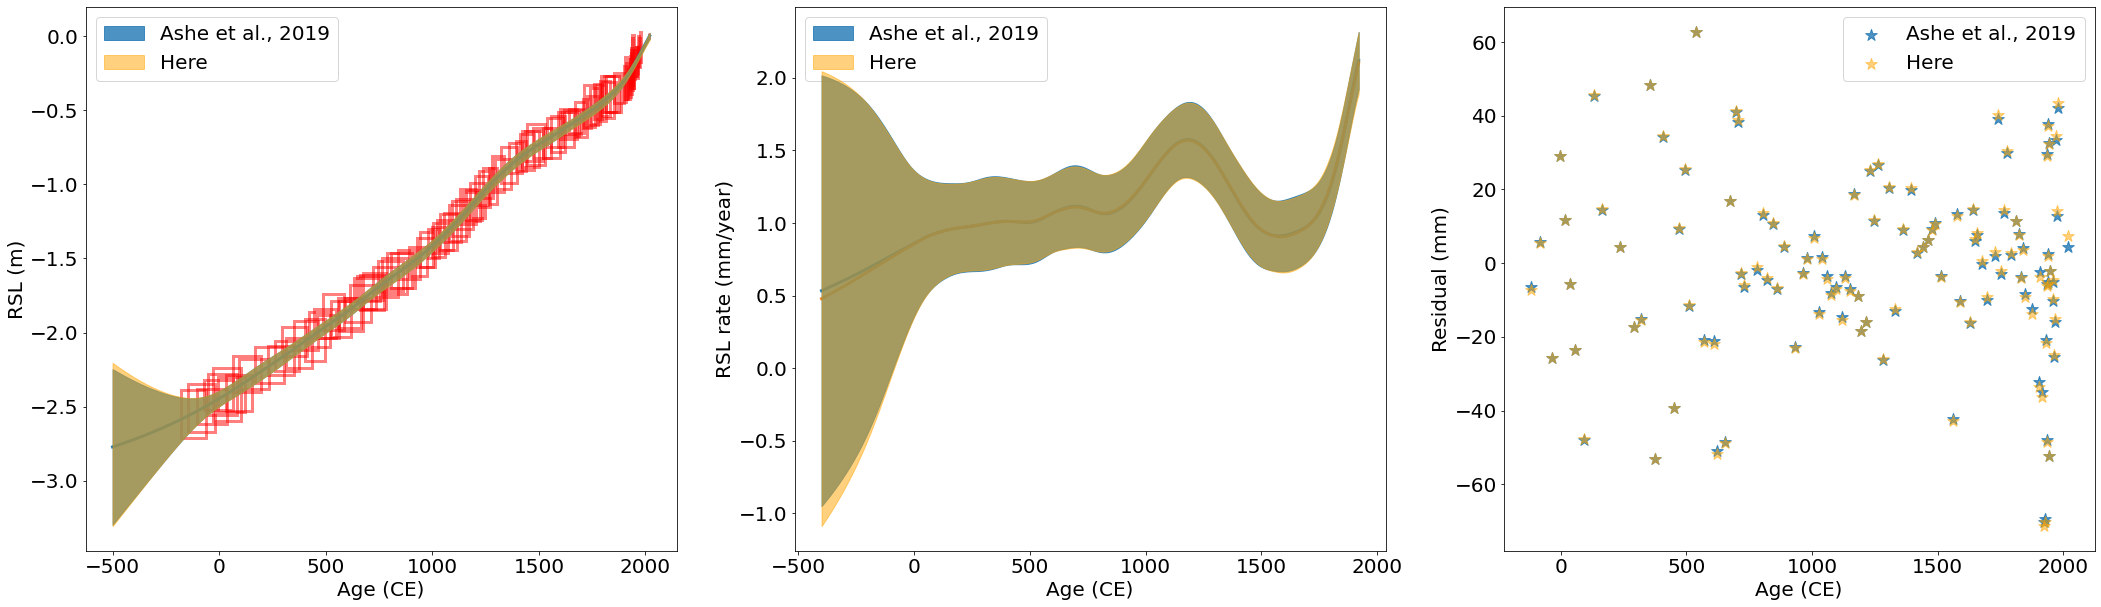

In [36]:
#compare it with the result from the original paper from Ashe et al., 2019
ashe_NNC_mean_rsl =np.array(pd.read_csv('../Data/ashe_NNC_mean.csv',header=None))[:,0] /1000 #convert mm to m
NNC_cov_matrix = np.array(pd.read_csv('../Data/ashe_NNC_cov.csv',header=None)) 
NNC_ashe_sd = np.sqrt(np.diag(NNC_cov_matrix))/1000
NNC_rsl_time = np.arange(-500,2025,5.)
rsl_rate_time,NNC_ashe_rsl_rate,NNC_ashe_rsl_rate_sd = PSTHM.cal_rate_var(NNC_rsl_time,NNC_cov_matrix,ashe_NNC_mean_rsl)
NNC_ashe_rsl_rate_sd/=1000 #convert mm to m

#-----plotting---------
fig= plt.figure(figsize=(36, 10))
ax = plt.subplot(131)
ax = PSTHM.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,ax=ax)

plt.plot(NNC_rsl_time,ashe_NNC_mean_rsl,linewidth=3)
plt.fill_between(
            NNC_rsl_time,  # plot the two-sigma uncertainty about the mean
            (ashe_NNC_mean_rsl - 2.0 * NNC_ashe_sd),
            (ashe_NNC_mean_rsl + 2.0 * NNC_ashe_sd),
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al., 2019')

ax.fill_between(
            x_test.detach().numpy(),  # plot the two-sigma uncertainty about the mean
            (c_kernel_y_mean - 2.0 * c_kernel_sd).detach().numpy(),
            (c_kernel_y_mean + 2.0 * c_kernel_sd).detach().numpy(),
            color="orange",
            alpha=0.5,zorder=10,label='Here')
plt.legend()

ax = plt.subplot(132)
ax.plot(rsl_rate_time,NNC_ashe_rsl_rate*1000,linewidth=3)
plt.plot(rsl_time,c_kernel_rsl_rate*1000,linewidth=3)

ax.fill_between(
            rsl_rate_time,  # plot the two-sigma uncertainty about the mean
            (NNC_ashe_rsl_rate - 2.0 * NNC_ashe_rsl_rate_sd)*1000,
            (NNC_ashe_rsl_rate + 2.0 * NNC_ashe_rsl_rate_sd)*1000,
            color="C0",
            alpha=0.8,zorder=10,label='Ashe et al., 2019')
ax.fill_between(
            rsl_time,  # plot the two-sigma uncertainty about the mean
            (c_kernel_rsl_rate - 2.0 * c_kernel_rsl_rate_sd)*1000,
            (c_kernel_rsl_rate + 2.0 * c_kernel_rsl_rate_sd)*1000,
            color="orange",
            alpha=0.5,zorder=10,label='Here')

plt.xlabel('Age (CE)')
plt.ylabel('RSL rate (mm/year)')
plt.legend()

ax = plt.subplot(133)
f_NNC_ashe = interpolate.interp1d(NNC_rsl_time,ashe_NNC_mean_rsl)
plt.scatter(NNC_X,(NNC_y-f_NNC_ashe(NNC_X))*1000,s=150,marker='*',color='C0',alpha=0.8,label='Ashe et al., 2019')
plt.scatter(NNC_X,(NNC_y-pred_y.detach().numpy())*1000,s=150,marker='*',color='orange',label='Here',alpha=0.5)

plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.legend();


Great, we have now successfully replicate two sea-level reconstruction results by Ashe et al., 2019, hooray! You can now start to do GP regression based on your own data and self-defined GP kernels! 

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.

In [33]:
#Try it here!
